## Convolutional Neural Network (CNN) model

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import os
SAVING_DIR = r'C:\Users\Rabbil\Documents\BDA_thesis\thesis-project\outputs\models'

import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import BatchNormalization

from sklearn.preprocessing import RobustScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import sklearn.metrics as metrics # for model evaluation 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
df_by_hour = pd.read_csv(r'C:\Users\Rabbil\Documents\BDA_thesis\thesis-project\data\processed\cleaned_df_final.csv').drop(['index'], axis=1)
df_by_hour.head(2)

,date,Pressure,Humidity,Temperature,NO_s,NO2_s,O3_s,CO_s,NO,NO2,...,CO_rolling_min,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std
0,2019-03-01 06:00:00,100619.981389,19.921558,12.797778,0.070146,0.002855,0.059470,0.062104,0.010423,0.002472,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010128,0.001182,0.017390,0.003126
1,2019-03-01 07:00:00,100585.411944,23.175349,9.847472,0.053864,0.002855,0.059185,0.029971,0.009536,0.002502,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010123,0.001187,0.017379,0.003055


In [3]:
df_by_hour.set_index('date', inplace=True)
df_by_hour.head(2)

,Pressure,Humidity,Temperature,NO_s,NO2_s,O3_s,CO_s,NO,NO2,O3,...,CO_rolling_min,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std
date,,,,,,,,,,,,,,,,,,,,,
2019-03-01 06:00:00,100619.981389,19.921558,12.797778,0.070146,0.002855,0.059470,0.062104,0.010423,0.002472,0.000708,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010128,0.001182,0.017390,0.003126
2019-03-01 07:00:00,100585.411944,23.175349,9.847472,0.053864,0.002855,0.059185,0.029971,0.009536,0.002502,0.000517,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010123,0.001187,0.017379,0.003055


In [4]:
# sub-selecting data 
df_by_hour= df_by_hour.loc['2019-03':'2019-06']
df_by_hour.drop(['Day'], axis=1, inplace =True)

In [5]:
df_by_hour.columns

Index(['Pressure', 'Humidity', 'Temperature', 'NO_s', 'NO2_s', 'O3_s', 'CO_s',
       'NO', 'NO2', 'O3', 'CO', 'Hour', 'Day_of_week', 'Day_of_month', 'Month',
       'is_weekday', 'daypart', 'Season', 'NO_lag_feature', 'NO2_lag_feature',
       'CO_lag_feature', 'O3_lag_feature', 'NO_rolling_mean',
       'NO2_rolling_mean', 'CO_rolling_mean', 'O3_rolling_mean',
       'NO_rolling_min', 'NO2_rolling_min', 'CO_rolling_min', 'O3_rolling_min',
       'NO_rolling_max', 'NO2_rolling_max', 'CO_rolling_max', 'O3_rolling_max',
       'NO_rolling_std', 'NO2_rolling_std', 'CO_rolling_std',
       'O3_rolling_std'],
      dtype='object')

### Machine learning data preparation 

In [6]:
# Spliting the data into train and test sets
train_size = int(len(df_by_hour)*0.8)
test_size = len(df_by_hour) - train_size

train, test = df_by_hour.iloc[0:train_size], df_by_hour.iloc[train_size:len(df_by_hour)]

print(train.shape, test.shape)

(1761, 38) (441, 38)


In [7]:
# Scaling of data

# creating variables for list of columns with scaler
feature_columns = ['Pressure', 'Humidity', 'Temperature','NO', 'NO2', 'CO',
         'NO_s', 'NO2_s','O3_s', 'CO_s', 'Hour','Day_of_week', 'is_weekday', 'daypart',
        'NO_rolling_mean', 'NO2_rolling_mean', 'CO_rolling_mean',
        'O3_rolling_mean', 'NO_rolling_min', 'NO2_rolling_min',
        'CO_rolling_min', 'O3_rolling_min', 'NO_rolling_max', 'NO2_rolling_max',
        'CO_rolling_max', 'O3_rolling_max',
        'O3_rolling_std']
#target_columns = ['NO']

feature_transformer = MinMaxScaler()
NO_transformer = MinMaxScaler()

# fit the scaler on training data
feature_transformer = feature_transformer.fit(train[feature_columns])
NO_transformer = NO_transformer.fit(train[['NO']])

In [8]:
train.loc[:, feature_columns] = feature_transformer.transform(train[feature_columns])
train['NO'] = NO_transformer.transform(train[['NO']])

test.loc[:, feature_columns] = feature_transformer.transform(test[feature_columns])
test['NO'] = NO_transformer.transform(test[['NO']])

In [9]:
# Making the time series data into sub sequences by writing a funciton
# split a multivariate sequene into samples
import numpy as np 
def create_dataset(X, y, time_steps=1): # X=features, y=labels, time_steps= history of sequence
    Xs, ys = [], [] # create two lists
    for i in range(len(X) - time_steps): #loops for the subsequent steps
        values = X.iloc[i: (i + time_steps)]
        Xs.append(values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

#x = np.asarray(x).astype('float32')
#x_train = np.asarray(x_train).astype(np.float32)
#y_train = np.asarray(y_train).astype(np.float32)

In [10]:
# Specify number of time steps
TIME_STEPS = 48 # history of 24 hours to predict for the next 24 hours

# Creating actual taining and test dataset
# Reshaping to samples, time_steps and n_features
X_train, y_train = create_dataset(train, train.NO, time_steps= TIME_STEPS)
X_test, y_test = create_dataset(test, test.NO, time_steps= TIME_STEPS)

In [11]:
# printing number of samples, number of time_steps and number of features
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1713, 48, 38) (1713,)
(393, 48, 38) (393,)


In [12]:
# print the first sequence
#X_test[0].shape
X_test[0][0].shape, X_train[0][0].shape

((38,), (38,))

In [13]:
# creating function for CNN model

def create_model(optimizer='adam', dropout_rate=0.2, activation='relu', batches=16):
    model_cnn = Sequential()
    #input_shape=(n_steps, n_features)
    model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model_cnn.add(MaxPooling1D(pool_size=2))

    model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model_cnn.add(MaxPooling1D(pool_size=2))

    model_cnn.add(Flatten())

    model_cnn.add(Dense(64, activation='relu'))
    model_cnn.add(Dropout(0.2))

    model_cnn.add(Dense(32, activation='relu'))
    model_cnn.add(Dropout(0.2))

    model_cnn.add(Dense(1))
    model_cnn.compile(optimizer=optimizer, loss='mse')
    
    return model_cnn


model_cnn = create_model()
model_cnn.summary()

# Saving the model
my_path = SAVING_DIR
my_file = "model_cnn.h5"
model_cnn.save_weights(os.path.join(my_path, my_file))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 47, 64)            4928      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 64)            8256      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 704)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                45120     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [20]:
%%time
seed = 7
np.random.seed(seed)

cnn_history = model_cnn.fit(X_train, y_train, 
                        epochs = 40,
                        batch_size=16,
                        validation_split=0.3,
                        shuffle=False
                       )

Train on 1199 samples, validate on 514 samples
Epoch 1/40
1199/1199 [==============================] - 1s 592us/sample - loss: 0.7326 - val_loss: 0.6875
Epoch 2/40
1199/1199 [==============================] - 1s 594us/sample - loss: 0.6537 - val_loss: 0.6852
Epoch 3/40
1199/1199 [==============================] - 1s 592us/sample - loss: 0.7359 - val_loss: 0.5703
Epoch 4/40
1199/1199 [==============================] - 1s 533us/sample - loss: 0.6134 - val_loss: 0.5416
Epoch 5/40
1199/1199 [==============================] - 1s 603us/sample - loss: 0.6643 - val_loss: 0.7892
Epoch 6/40
1199/1199 [==============================] - 1s 610us/sample - loss: 0.5481 - val_loss: 0.5089
Epoch 7/40
1199/1199 [==============================] - 1s 599us/sample - loss: 0.4992 - val_loss: 0.4792
Epoch 8/40
1199/1199 [==============================] - 1s 573us/sample - loss: 0.5351 - val_loss: 0.8698
Epoch 9/40
1199/1199 [==============================] - 1s 584us/sample - loss: 0.5280 - val_loss: 0.6205

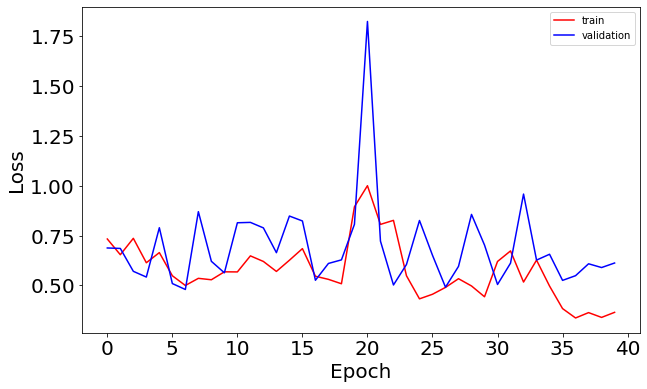

In [21]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.plot(cnn_history.history['loss'], 'r', label='train')
plt.plot(cnn_history.history['val_loss'], 'b', label='validation')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)


# Save the plot
my_path = SAVING_DIR
my_file = 'CNN_model_NO.png'
plt.savefig(os.path.join(my_path, my_file))

In [24]:
# making prediction
y_pred_cnn = model_cnn.predict(X_test)

In [26]:
# function for calculating MAPE
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))*100

# Model evaluation using mean square error (MSE)
print('r Squared Error:' , metrics.r2_score(y_test, y_pred_cnn))
print('Mean Squared Error:' , metrics.mean_squared_error(y_test, y_pred_cnn))
# Model evaluation using  root mean squared error (RMSE): value 1 deptics worst model
print('Root Mean Squared Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred_cnn)))
# Model evaluation using mean absolute error (MAE): value 0 deptics best model
print('Mean Absolute Error:' , metrics.mean_absolute_error(y_test, y_pred_cnn))
print('MAPE:' , mape(y_test, y_pred_cnn))

r Squared Error: 0.6152433313461203
Mean Squared Error: 1.6410611719943955
Root Mean Squared Error: 1.2810390985424276
Mean Absolute Error: 0.7251127976853724
MAPE: 124.99072677665708


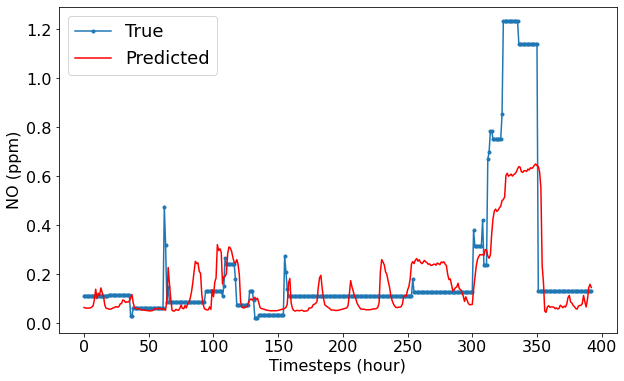

In [39]:
# use inverse the scaler for the feature variable
# invert the X_train, y_train and predicted data
y_train_inv = NO_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = NO_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = NO_transformer.inverse_transform(y_pred_cnn)

# plotting the predicted value
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.plot(y_test_inv.flatten(), marker='.', label='True')
plt.plot(y_pred_inv.flatten(), 'r', label='Predicted')

ax.set_xlabel(r'Timesteps (hour)', fontsize=16)
ax.set_ylabel(r'NO (ppm)', fontsize=16)
ax.legend()
ax.tick_params(labelsize=16)
#plt.ylabel('Global_active_power', size=15)
#plt.xlabel('Time step', size=15)
plt.legend(fontsize=18)

my_path = SAVING_DIR
my_file = 'cnn_prediction_NO'
plt.savefig(os.path.join(my_path, my_file), dpi=300, bbox_inches='tight')


### Tunning hyperparameter using cross vlaidation : by using GridSearchCV from Scikit-Learn

In [42]:
%%time
seed = 7 # fix random seed for reproducibility
np.random.seed(seed)


# create the sklearn model for the network
model_batch_epoch = KerasRegressor(build_fn=create_model, verbose=1)


# we choose the initializers that came at the top in our previous cross-validation!!
#init_mode = ['glorot_uniform', 'uniform'] 
#layer_size= [32, 64, 128]
batches = [16, 32, 64]
epochs = [20, 30, 40]
#learn_rate= [0.001,0.01, 0.1 ]
dropout_rate=[0.2, 0.3]
optimizer=['Adam', 'RMSProp']
#activation=['sigmoid', 'relu']

# grid search for initializer
param_grid = dict( batches=batches, epochs=epochs, dropout_rate=dropout_rate, optimizer=optimizer)
grid = GridSearchCV(estimator=model_batch_epoch,
                    param_grid=param_grid,
                    cv=3)
grid_result = grid.fit(X_train, y_train)

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.2327
Epoch 2/20
1142/1142 [==============================] - 0s 342us/sample - loss: 1.4695
Epoch 3/20
1142/1142 [==============================] - 0s 357us/sample - loss: 1.3584
Epoch 4/20
1142/1142 [==============================] - 0s 357us/sample - loss: 1.0758
Epoch 5/20
1142/1142 [==============================] - 0s 366us/sample - loss: 1.0486
Epoch 6/20
1142/1142 [==============================] - 0s 356us/sample - loss: 0.9726
Epoch 7/20
1142/1142 [==============================] - 0s 365us/sample - loss: 0.9045
Epoch 8/20
1142/1142 [==============================] - 0s 354us/sample - loss: 0.9141
Epoch 9/20
1142/1142 [==============================] - 0s 353us/sample - loss: 0.8224
Epoch 10/20
1142/1142 [==============================] - 0s 350us/sample - loss: 0.7266s - loss: 0
Epoch 11/20
1142/1142 [==============================] - 0s 319us/sample - loss: 0.7081
Epoch 12/2

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.7904
Epoch 2/20
1142/1142 [==============================] - 0s 365us/sample - loss: 1.1603
Epoch 3/20
1142/1142 [==============================] - 0s 335us/sample - loss: 0.9504
Epoch 4/20
1142/1142 [==============================] - 0s 338us/sample - loss: 0.7345
Epoch 5/20
1142/1142 [==============================] - 0s 345us/sample - loss: 0.6463
Epoch 6/20
1142/1142 [==============================] - 0s 356us/sample - loss: 0.6553
Epoch 7/20
1142/1142 [==============================] - 0s 329us/sample - loss: 0.5691
Epoch 8/20
1142/1142 [==============================] - 0s 357us/sample - loss: 0.5756
Epoch 9/20
1142/1142 [==============================] - 0s 320us/sample - loss: 0.5042
Epoch 10/20
1142/1142 [==============================] - 0s 351us/sample - loss: 0.5077
Epoch 11/20
1142/1142 [==============================] - 0s 358us/sample - loss: 0.5359
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 3.4415
Epoch 2/20
1142/1142 [==============================] - 0s 390us/sample - loss: 1.9403
Epoch 3/20
1142/1142 [==============================] - 0s 408us/sample - loss: 1.4691
Epoch 4/20
1142/1142 [==============================] - 0s 371us/sample - loss: 1.1955
Epoch 5/20
1142/1142 [==============================] - 0s 344us/sample - loss: 1.1294
Epoch 6/20
1142/1142 [==============================] - 0s 392us/sample - loss: 0.9824
Epoch 7/20
1142/1142 [==============================] - 0s 348us/sample - loss: 1.0072
Epoch 8/20
1142/1142 [==============================] - 0s 345us/sample - loss: 0.8741
Epoch 9/20
1142/1142 [==============================] - 0s 337us/sample - loss: 0.8823
Epoch 10/20
1142/1142 [==============================] - 0s 387us/sample - loss: 0.8728
Epoch 11/20
1142/1142 [==============================] - 0s 353us/sample - loss: 0.8378
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.9019
Epoch 2/20
1142/1142 [==============================] - 0s 355us/sample - loss: 1.7818
Epoch 3/20
1142/1142 [==============================] - 0s 351us/sample - loss: 1.6237
Epoch 4/20
1142/1142 [==============================] - 0s 437us/sample - loss: 1.4145
Epoch 5/20
1142/1142 [==============================] - 0s 353us/sample - loss: 1.1447
Epoch 6/20
1142/1142 [==============================] - 0s 343us/sample - loss: 1.1504
Epoch 7/20
1142/1142 [==============================] - 0s 397us/sample - loss: 0.9851
Epoch 8/20
1142/1142 [==============================] - 0s 398us/sample - loss: 1.0199
Epoch 9/20
1142/1142 [==============================] - 0s 426us/sample - loss: 0.9295
Epoch 10/20
1142/1142 [==============================] - 0s 408us/sample - loss: 0.9001
Epoch 11/20
1142/1142 [==============================] - 0s 408us/sample - loss: 0.8839
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.7865
Epoch 2/20
1142/1142 [==============================] - 0s 385us/sample - loss: 1.3294
Epoch 3/20
1142/1142 [==============================] - 0s 349us/sample - loss: 1.0950
Epoch 4/20
1142/1142 [==============================] - 0s 343us/sample - loss: 0.8998
Epoch 5/20
1142/1142 [==============================] - 0s 354us/sample - loss: 0.8228
Epoch 6/20
1142/1142 [==============================] - 0s 354us/sample - loss: 0.6716
Epoch 7/20
1142/1142 [==============================] - 0s 338us/sample - loss: 0.6640
Epoch 8/20
1142/1142 [==============================] - 0s 363us/sample - loss: 0.6668
Epoch 9/20
1142/1142 [==============================] - 0s 397us/sample - loss: 0.5953
Epoch 10/20
1142/1142 [==============================] - 0s 356us/sample - loss: 0.5382
Epoch 11/20
1142/1142 [==============================] - 0s 386us/sample - loss: 0.5144
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 5.7671
Epoch 2/20
1142/1142 [==============================] - 0s 376us/sample - loss: 2.3077
Epoch 3/20
1142/1142 [==============================] - 0s 408us/sample - loss: 1.8450
Epoch 4/20
1142/1142 [==============================] - 0s 396us/sample - loss: 1.6318
Epoch 5/20
1142/1142 [==============================] - 0s 427us/sample - loss: 1.1707
Epoch 6/20
1142/1142 [==============================] - 0s 424us/sample - loss: 1.0765
Epoch 7/20
1142/1142 [==============================] - 0s 398us/sample - loss: 1.0922
Epoch 8/20
1142/1142 [==============================] - 0s 359us/sample - loss: 0.9048
Epoch 9/20
1142/1142 [==============================] - 0s 353us/sample - loss: 0.7615
Epoch 10/20
1142/1142 [==============================] - 0s 356us/sample - loss: 0.8073
Epoch 11/20
1142/1142 [==============================] - 0s 353us/sample - loss: 0.7390
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.2367
Epoch 2/30
1142/1142 [==============================] - 0s 407us/sample - loss: 1.2818
Epoch 3/30
1142/1142 [==============================] - 0s 364us/sample - loss: 1.1091
Epoch 4/30
1142/1142 [==============================] - 0s 373us/sample - loss: 0.9204
Epoch 5/30
1142/1142 [==============================] - 0s 376us/sample - loss: 0.9311
Epoch 6/30
1142/1142 [==============================] - 0s 352us/sample - loss: 0.9289
Epoch 7/30
1142/1142 [==============================] - 0s 370us/sample - loss: 0.8074
Epoch 8/30
1142/1142 [==============================] - 0s 364us/sample - loss: 0.8013
Epoch 9/30
1142/1142 [==============================] - 0s 350us/sample - loss: 0.6953
Epoch 10/30
1142/1142 [==============================] - 0s 367us/sample - loss: 0.6889
Epoch 11/30
1142/1142 [==============================] - 0s 390us/sample - loss: 0.6344
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.8930
Epoch 2/30
1142/1142 [==============================] - 0s 355us/sample - loss: 1.4770
Epoch 3/30
1142/1142 [==============================] - 0s 373us/sample - loss: 1.1829
Epoch 4/30
1142/1142 [==============================] - 0s 378us/sample - loss: 0.9419
Epoch 5/30
1142/1142 [==============================] - 0s 376us/sample - loss: 0.8083
Epoch 6/30
1142/1142 [==============================] - 0s 349us/sample - loss: 0.8174
Epoch 7/30
1142/1142 [==============================] - 0s 364us/sample - loss: 0.6275
Epoch 8/30
1142/1142 [==============================] - 0s 359us/sample - loss: 0.5822
Epoch 9/30
1142/1142 [==============================] - 0s 361us/sample - loss: 0.5393
Epoch 10/30
1142/1142 [==============================] - 0s 356us/sample - loss: 0.5210
Epoch 11/30
1142/1142 [==============================] - 0s 368us/sample - loss: 0.5472
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.3982
Epoch 2/30
1142/1142 [==============================] - 0s 348us/sample - loss: 1.6824
Epoch 3/30
1142/1142 [==============================] - 0s 355us/sample - loss: 1.2934
Epoch 4/30
1142/1142 [==============================] - 0s 391us/sample - loss: 1.1284
Epoch 5/30
1142/1142 [==============================] - 0s 381us/sample - loss: 0.9763
Epoch 6/30
1142/1142 [==============================] - 0s 368us/sample - loss: 1.0293
Epoch 7/30
1142/1142 [==============================] - 0s 344us/sample - loss: 0.9141
Epoch 8/30
1142/1142 [==============================] - 0s 342us/sample - loss: 0.8474
Epoch 9/30
1142/1142 [==============================] - 0s 413us/sample - loss: 0.9153
Epoch 10/30
1142/1142 [==============================] - 0s 377us/sample - loss: 0.7840
Epoch 11/30
1142/1142 [==============================] - 0s 350us/sample - loss: 0.7772
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.2171
Epoch 2/30
1142/1142 [==============================] - 0s 364us/sample - loss: 1.6478
Epoch 3/30
1142/1142 [==============================] - 0s 350us/sample - loss: 1.3218
Epoch 4/30
1142/1142 [==============================] - 0s 369us/sample - loss: 1.1891
Epoch 5/30
1142/1142 [==============================] - 0s 371us/sample - loss: 1.1017s - loss: 1
Epoch 6/30
1142/1142 [==============================] - 0s 312us/sample - loss: 1.0859
Epoch 7/30
1142/1142 [==============================] - 0s 369us/sample - loss: 0.9400
Epoch 8/30
1142/1142 [==============================] - 0s 367us/sample - loss: 0.8800
Epoch 9/30
1142/1142 [==============================] - 0s 343us/sample - loss: 0.8103
Epoch 10/30
1142/1142 [==============================] - 0s 357us/sample - loss: 0.8181
Epoch 11/30
1142/1142 [==============================] - 0s 350us/sample - loss: 0.7462
Epoch 12/3

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.6626
Epoch 2/30
1142/1142 [==============================] - 0s 284us/sample - loss: 1.5153
Epoch 3/30
1142/1142 [==============================] - 0s 358us/sample - loss: 1.2480
Epoch 4/30
1142/1142 [==============================] - 0s 336us/sample - loss: 1.0286
Epoch 5/30
1142/1142 [==============================] - 0s 387us/sample - loss: 0.8784
Epoch 6/30
1142/1142 [==============================] - 0s 350us/sample - loss: 0.8009
Epoch 7/30
1142/1142 [==============================] - 0s 329us/sample - loss: 0.7113
Epoch 8/30
1142/1142 [==============================] - 0s 329us/sample - loss: 0.6824
Epoch 9/30
1142/1142 [==============================] - 0s 351us/sample - loss: 0.6096
Epoch 10/30
1142/1142 [==============================] - 0s 336us/sample - loss: 0.5967
Epoch 11/30
1142/1142 [==============================] - 0s 342us/sample - loss: 0.6214
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.7890
Epoch 2/30
1142/1142 [==============================] - 0s 328us/sample - loss: 2.1851
Epoch 3/30
1142/1142 [==============================] - 0s 384us/sample - loss: 1.6816
Epoch 4/30
1142/1142 [==============================] - 0s 359us/sample - loss: 1.4279
Epoch 5/30
1142/1142 [==============================] - 0s 416us/sample - loss: 1.3078
Epoch 6/30
1142/1142 [==============================] - 0s 381us/sample - loss: 1.0555
Epoch 7/30
1142/1142 [==============================] - 0s 339us/sample - loss: 1.0230
Epoch 8/30
1142/1142 [==============================] - 0s 351us/sample - loss: 1.0522
Epoch 9/30
1142/1142 [==============================] - 0s 346us/sample - loss: 0.8957
Epoch 10/30
1142/1142 [==============================] - 0s 388us/sample - loss: 0.8640
Epoch 11/30
1142/1142 [==============================] - 0s 350us/sample - loss: 0.8268
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.1230
Epoch 2/40
1142/1142 [==============================] - 0s 349us/sample - loss: 1.3544
Epoch 3/40
1142/1142 [==============================] - 0s 358us/sample - loss: 1.2523
Epoch 4/40
1142/1142 [==============================] - 0s 352us/sample - loss: 1.0686
Epoch 5/40
1142/1142 [==============================] - 0s 312us/sample - loss: 0.9703
Epoch 6/40
1142/1142 [==============================] - 0s 350us/sample - loss: 0.8652
Epoch 7/40
1142/1142 [==============================] - 0s 343us/sample - loss: 0.7576
Epoch 8/40
1142/1142 [==============================] - 0s 345us/sample - loss: 0.8527
Epoch 9/40
1142/1142 [==============================] - 0s 343us/sample - loss: 0.7406
Epoch 10/40
1142/1142 [==============================] - 0s 333us/sample - loss: 0.7545
Epoch 11/40
1142/1142 [==============================] - 0s 334us/sample - loss: 0.7383
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.8708
Epoch 2/40
1142/1142 [==============================] - 0s 381us/sample - loss: 1.3175
Epoch 3/40
1142/1142 [==============================] - 0s 370us/sample - loss: 1.0587
Epoch 4/40
1142/1142 [==============================] - 0s 375us/sample - loss: 0.9227
Epoch 5/40
1142/1142 [==============================] - 0s 375us/sample - loss: 0.7869
Epoch 6/40
1142/1142 [==============================] - 0s 387us/sample - loss: 0.7292
Epoch 7/40
1142/1142 [==============================] - 0s 391us/sample - loss: 0.6508
Epoch 8/40
1142/1142 [==============================] - 0s 382us/sample - loss: 0.6192
Epoch 9/40
1142/1142 [==============================] - 0s 376us/sample - loss: 0.5706
Epoch 10/40
1142/1142 [==============================] - 0s 380us/sample - loss: 0.5582
Epoch 11/40
1142/1142 [==============================] - 0s 378us/sample - loss: 0.5597
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.7343
Epoch 2/40
1142/1142 [==============================] - 0s 294us/sample - loss: 1.7593
Epoch 3/40
1142/1142 [==============================] - 0s 220us/sample - loss: 1.3427
Epoch 4/40
1142/1142 [==============================] - 0s 325us/sample - loss: 1.1870
Epoch 5/40
1142/1142 [==============================] - 0s 390us/sample - loss: 1.0516s - loss: 1
Epoch 6/40
1142/1142 [==============================] - 0s 384us/sample - loss: 1.0584
Epoch 7/40
1142/1142 [==============================] - 0s 352us/sample - loss: 0.7860
Epoch 8/40
1142/1142 [==============================] - 0s 369us/sample - loss: 0.8272
Epoch 9/40
1142/1142 [==============================] - 0s 378us/sample - loss: 0.7711
Epoch 10/40
1142/1142 [==============================] - 0s 389us/sample - loss: 0.7464
Epoch 11/40
1142/1142 [==============================] - 0s 353us/sample - loss: 0.7448
Epoch 12/4

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.1579
Epoch 2/40
1142/1142 [==============================] - 0s 375us/sample - loss: 1.8235
Epoch 3/40
1142/1142 [==============================] - 0s 384us/sample - loss: 1.3694
Epoch 4/40
1142/1142 [==============================] - 0s 361us/sample - loss: 1.3093
Epoch 5/40
1142/1142 [==============================] - 0s 389us/sample - loss: 1.1002
Epoch 6/40
1142/1142 [==============================] - 0s 392us/sample - loss: 1.1107
Epoch 7/40
1142/1142 [==============================] - 0s 350us/sample - loss: 1.0721
Epoch 8/40
1142/1142 [==============================] - 0s 402us/sample - loss: 0.9274
Epoch 9/40
1142/1142 [==============================] - 0s 346us/sample - loss: 0.9256
Epoch 10/40
1142/1142 [==============================] - 0s 352us/sample - loss: 0.8985
Epoch 11/40
1142/1142 [==============================] - 0s 373us/sample - loss: 0.7744
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.9869
Epoch 2/40
1142/1142 [==============================] - 0s 350us/sample - loss: 1.3639
Epoch 3/40
1142/1142 [==============================] - 0s 371us/sample - loss: 0.9785
Epoch 4/40
1142/1142 [==============================] - 0s 342us/sample - loss: 0.8473
Epoch 5/40
1142/1142 [==============================] - 0s 377us/sample - loss: 0.7949
Epoch 6/40
1142/1142 [==============================] - 0s 350us/sample - loss: 0.6698
Epoch 7/40
1142/1142 [==============================] - 0s 352us/sample - loss: 0.5930
Epoch 8/40
1142/1142 [==============================] - 0s 365us/sample - loss: 0.6382
Epoch 9/40
1142/1142 [==============================] - 0s 355us/sample - loss: 0.5964
Epoch 10/40
1142/1142 [==============================] - 0s 345us/sample - loss: 0.5434
Epoch 11/40
1142/1142 [==============================] - 0s 355us/sample - loss: 0.5007
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.3837
Epoch 2/40
1142/1142 [==============================] - 0s 372us/sample - loss: 1.9160
Epoch 3/40
1142/1142 [==============================] - 0s 370us/sample - loss: 1.7229
Epoch 4/40
1142/1142 [==============================] - 0s 351us/sample - loss: 1.3610
Epoch 5/40
1142/1142 [==============================] - 0s 351us/sample - loss: 1.1985
Epoch 6/40
1142/1142 [==============================] - 0s 367us/sample - loss: 1.0840
Epoch 7/40
1142/1142 [==============================] - 0s 362us/sample - loss: 1.0424
Epoch 8/40
1142/1142 [==============================] - 0s 335us/sample - loss: 1.0582
Epoch 9/40
1142/1142 [==============================] - 0s 343us/sample - loss: 0.9022
Epoch 10/40
1142/1142 [==============================] - 0s 357us/sample - loss: 0.8419
Epoch 11/40
1142/1142 [==============================] - 0s 347us/sample - loss: 0.8771
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.5450
Epoch 2/20
1142/1142 [==============================] - 0s 374us/sample - loss: 1.7035
Epoch 3/20
1142/1142 [==============================] - 0s 375us/sample - loss: 1.4219
Epoch 4/20
1142/1142 [==============================] - 0s 369us/sample - loss: 1.3015
Epoch 5/20
1142/1142 [==============================] - 0s 384us/sample - loss: 1.1674
Epoch 6/20
1142/1142 [==============================] - 0s 367us/sample - loss: 1.0426
Epoch 7/20
1142/1142 [==============================] - 0s 383us/sample - loss: 1.0005
Epoch 8/20
1142/1142 [==============================] - 0s 350us/sample - loss: 0.8387
Epoch 9/20
1142/1142 [==============================] - 0s 364us/sample - loss: 0.8274
Epoch 10/20
1142/1142 [==============================] - 0s 383us/sample - loss: 0.7666
Epoch 11/20
1142/1142 [==============================] - 0s 362us/sample - loss: 0.7598s - loss: 
Epoch 12/20

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.3279
Epoch 2/20
1142/1142 [==============================] - 0s 273us/sample - loss: 1.4256
Epoch 3/20
1142/1142 [==============================] - 0s 369us/sample - loss: 1.1677
Epoch 4/20
1142/1142 [==============================] - 0s 359us/sample - loss: 0.9330
Epoch 5/20
1142/1142 [==============================] - 0s 364us/sample - loss: 0.8808
Epoch 6/20
1142/1142 [==============================] - 0s 372us/sample - loss: 0.7881
Epoch 7/20
1142/1142 [==============================] - 0s 334us/sample - loss: 0.7317
Epoch 8/20
1142/1142 [==============================] - 0s 379us/sample - loss: 0.6846
Epoch 9/20
1142/1142 [==============================] - 0s 367us/sample - loss: 0.6500
Epoch 10/20
1142/1142 [==============================] - 0s 397us/sample - loss: 0.6011
Epoch 11/20
1142/1142 [==============================] - 0s 346us/sample - loss: 0.5399
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.7514
Epoch 2/20
1142/1142 [==============================] - 0s 387us/sample - loss: 1.6952
Epoch 3/20
1142/1142 [==============================] - 0s 360us/sample - loss: 1.3431
Epoch 4/20
1142/1142 [==============================] - 0s 353us/sample - loss: 1.1296
Epoch 5/20
1142/1142 [==============================] - 0s 340us/sample - loss: 0.9980
Epoch 6/20
1142/1142 [==============================] - 0s 323us/sample - loss: 1.0292
Epoch 7/20
1142/1142 [==============================] - 0s 372us/sample - loss: 0.9065
Epoch 8/20
1142/1142 [==============================] - 0s 329us/sample - loss: 0.7999
Epoch 9/20
1142/1142 [==============================] - 0s 359us/sample - loss: 0.8381
Epoch 10/20
1142/1142 [==============================] - 0s 353us/sample - loss: 0.8032
Epoch 11/20
1142/1142 [==============================] - 0s 344us/sample - loss: 0.7538
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.2686
Epoch 2/20
1142/1142 [==============================] - 0s 358us/sample - loss: 1.7795
Epoch 3/20
1142/1142 [==============================] - 0s 363us/sample - loss: 1.5093
Epoch 4/20
1142/1142 [==============================] - 0s 365us/sample - loss: 1.3143
Epoch 5/20
1142/1142 [==============================] - 0s 367us/sample - loss: 1.0755
Epoch 6/20
1142/1142 [==============================] - 0s 356us/sample - loss: 0.9960
Epoch 7/20
1142/1142 [==============================] - 0s 374us/sample - loss: 0.9599
Epoch 8/20
1142/1142 [==============================] - 0s 341us/sample - loss: 0.8921
Epoch 9/20
1142/1142 [==============================] - 0s 352us/sample - loss: 0.8226
Epoch 10/20
1142/1142 [==============================] - 0s 356us/sample - loss: 0.8560
Epoch 11/20
1142/1142 [==============================] - 0s 329us/sample - loss: 0.7552
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.1593
Epoch 2/20
1142/1142 [==============================] - 0s 361us/sample - loss: 1.4546
Epoch 3/20
1142/1142 [==============================] - 0s 364us/sample - loss: 1.0958
Epoch 4/20
1142/1142 [==============================] - 0s 359us/sample - loss: 0.8939
Epoch 5/20
1142/1142 [==============================] - 0s 352us/sample - loss: 0.8302
Epoch 6/20
1142/1142 [==============================] - 0s 366us/sample - loss: 0.7693
Epoch 7/20
1142/1142 [==============================] - 0s 398us/sample - loss: 0.7215
Epoch 8/20
1142/1142 [==============================] - 0s 349us/sample - loss: 0.6755
Epoch 9/20
1142/1142 [==============================] - 0s 365us/sample - loss: 0.6985
Epoch 10/20
1142/1142 [==============================] - 0s 361us/sample - loss: 0.5774
Epoch 11/20
1142/1142 [==============================] - 0s 385us/sample - loss: 0.5565
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.9745
Epoch 2/20
1142/1142 [==============================] - 0s 355us/sample - loss: 1.9713
Epoch 3/20
1142/1142 [==============================] - 0s 378us/sample - loss: 1.5900
Epoch 4/20
1142/1142 [==============================] - 0s 363us/sample - loss: 1.3991
Epoch 5/20
1142/1142 [==============================] - 0s 355us/sample - loss: 1.1865
Epoch 6/20
1142/1142 [==============================] - 0s 365us/sample - loss: 1.0832
Epoch 7/20
1142/1142 [==============================] - 0s 351us/sample - loss: 1.0269
Epoch 8/20
1142/1142 [==============================] - 0s 363us/sample - loss: 0.9186
Epoch 9/20
1142/1142 [==============================] - 0s 356us/sample - loss: 0.9624
Epoch 10/20
1142/1142 [==============================] - 0s 362us/sample - loss: 0.8687
Epoch 11/20
1142/1142 [==============================] - 0s 350us/sample - loss: 0.7274
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.7815
Epoch 2/30
1142/1142 [==============================] - 0s 415us/sample - loss: 1.7082
Epoch 3/30
1142/1142 [==============================] - 0s 381us/sample - loss: 1.3989
Epoch 4/30
1142/1142 [==============================] - 0s 354us/sample - loss: 1.1953
Epoch 5/30
1142/1142 [==============================] - 0s 365us/sample - loss: 1.1418
Epoch 6/30
1142/1142 [==============================] - 0s 379us/sample - loss: 1.0729
Epoch 7/30
1142/1142 [==============================] - 0s 366us/sample - loss: 0.9676
Epoch 8/30
1142/1142 [==============================] - 0s 370us/sample - loss: 0.8554
Epoch 9/30
1142/1142 [==============================] - 0s 380us/sample - loss: 0.9632
Epoch 10/30
1142/1142 [==============================] - 0s 366us/sample - loss: 0.8769
Epoch 11/30
1142/1142 [==============================] - 0s 393us/sample - loss: 0.7615
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.4088
Epoch 2/30
1142/1142 [==============================] - 0s 387us/sample - loss: 1.0402
Epoch 3/30
1142/1142 [==============================] - 0s 391us/sample - loss: 0.7775
Epoch 4/30
1142/1142 [==============================] - 0s 356us/sample - loss: 0.7097
Epoch 5/30
1142/1142 [==============================] - 0s 390us/sample - loss: 0.6040
Epoch 6/30
1142/1142 [==============================] - 0s 350us/sample - loss: 0.5846
Epoch 7/30
1142/1142 [==============================] - 0s 358us/sample - loss: 0.5631
Epoch 8/30
1142/1142 [==============================] - 0s 368us/sample - loss: 0.5245
Epoch 9/30
1142/1142 [==============================] - 0s 373us/sample - loss: 0.4991
Epoch 10/30
1142/1142 [==============================] - 0s 375us/sample - loss: 0.5219
Epoch 11/30
1142/1142 [==============================] - 0s 374us/sample - loss: 0.4541
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.5934
Epoch 2/30
1142/1142 [==============================] - 0s 311us/sample - loss: 1.7132
Epoch 3/30
1142/1142 [==============================] - 0s 357us/sample - loss: 1.3235
Epoch 4/30
1142/1142 [==============================] - 0s 360us/sample - loss: 1.2617
Epoch 5/30
1142/1142 [==============================] - 0s 309us/sample - loss: 1.0241
Epoch 6/30
1142/1142 [==============================] - 0s 360us/sample - loss: 0.9927
Epoch 7/30
1142/1142 [==============================] - 0s 346us/sample - loss: 0.8637
Epoch 8/30
1142/1142 [==============================] - 0s 309us/sample - loss: 0.9001
Epoch 9/30
1142/1142 [==============================] - 0s 356us/sample - loss: 0.8483
Epoch 10/30
1142/1142 [==============================] - 0s 343us/sample - loss: 0.7685
Epoch 11/30
1142/1142 [==============================] - 0s 354us/sample - loss: 0.7514
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.9945
Epoch 2/30
1142/1142 [==============================] - 0s 354us/sample - loss: 1.8483
Epoch 3/30
1142/1142 [==============================] - 0s 346us/sample - loss: 1.5962
Epoch 4/30
1142/1142 [==============================] - 0s 377us/sample - loss: 1.3223
Epoch 5/30
1142/1142 [==============================] - 0s 380us/sample - loss: 1.2599
Epoch 6/30
1142/1142 [==============================] - 0s 351us/sample - loss: 1.1365
Epoch 7/30
1142/1142 [==============================] - 0s 365us/sample - loss: 1.0965
Epoch 8/30
1142/1142 [==============================] - 0s 348us/sample - loss: 0.9349
Epoch 9/30
1142/1142 [==============================] - 0s 365us/sample - loss: 1.0335s - loss: 1.0
Epoch 10/30
1142/1142 [==============================] - 0s 364us/sample - loss: 0.8374
Epoch 11/30
1142/1142 [==============================] - 0s 344us/sample - loss: 0.8666
Epoch 12

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.9644
Epoch 2/30
1142/1142 [==============================] - 0s 355us/sample - loss: 1.3651
Epoch 3/30
1142/1142 [==============================] - 0s 373us/sample - loss: 1.0495
Epoch 4/30
1142/1142 [==============================] - 0s 334us/sample - loss: 0.8916
Epoch 5/30
1142/1142 [==============================] - 0s 369us/sample - loss: 0.7828
Epoch 6/30
1142/1142 [==============================] - 0s 377us/sample - loss: 0.6949
Epoch 7/30
1142/1142 [==============================] - 0s 366us/sample - loss: 0.6271
Epoch 8/30
1142/1142 [==============================] - 0s 389us/sample - loss: 0.5506
Epoch 9/30
1142/1142 [==============================] - 0s 362us/sample - loss: 0.5543
Epoch 10/30
1142/1142 [==============================] - 0s 342us/sample - loss: 0.5141
Epoch 11/30
1142/1142 [==============================] - 0s 349us/sample - loss: 0.5252
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - ETA: 0s - loss: 3.135 - 2s 2ms/sample - loss: 2.9681
Epoch 2/30
1142/1142 [==============================] - 0s 367us/sample - loss: 2.0028
Epoch 3/30
1142/1142 [==============================] - 0s 354us/sample - loss: 1.5959
Epoch 4/30
1142/1142 [==============================] - 0s 363us/sample - loss: 1.3561
Epoch 5/30
1142/1142 [==============================] - 0s 350us/sample - loss: 1.1855
Epoch 6/30
1142/1142 [==============================] - 0s 365us/sample - loss: 1.0975
Epoch 7/30
1142/1142 [==============================] - 0s 366us/sample - loss: 0.9537
Epoch 8/30
1142/1142 [==============================] - 0s 361us/sample - loss: 0.9657
Epoch 9/30
1142/1142 [==============================] - 0s 359us/sample - loss: 0.8845
Epoch 10/30
1142/1142 [==============================] - 0s 329us/sample - loss: 0.8203
Epoch 11/30
1142/1142 [==============================] - 0s 338us/sample - loss: 0.79

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.4015
Epoch 2/40
1142/1142 [==============================] - 0s 376us/sample - loss: 1.7083
Epoch 3/40
1142/1142 [==============================] - 0s 359us/sample - loss: 1.3016
Epoch 4/40
1142/1142 [==============================] - 0s 368us/sample - loss: 1.1787
Epoch 5/40
1142/1142 [==============================] - 0s 358us/sample - loss: 1.0223
Epoch 6/40
1142/1142 [==============================] - 0s 367us/sample - loss: 0.9497
Epoch 7/40
1142/1142 [==============================] - 0s 363us/sample - loss: 0.8097
Epoch 8/40
1142/1142 [==============================] - 0s 361us/sample - loss: 0.8621
Epoch 9/40
1142/1142 [==============================] - 0s 338us/sample - loss: 0.8826
Epoch 10/40
1142/1142 [==============================] - 0s 351us/sample - loss: 0.8497
Epoch 11/40
1142/1142 [==============================] - 0s 312us/sample - loss: 0.7568
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.7413
Epoch 2/40
1142/1142 [==============================] - 0s 285us/sample - loss: 1.2223
Epoch 3/40
1142/1142 [==============================] - 0s 339us/sample - loss: 0.8605
Epoch 4/40
1142/1142 [==============================] - 0s 349us/sample - loss: 0.7379
Epoch 5/40
1142/1142 [==============================] - 0s 358us/sample - loss: 0.6566
Epoch 6/40
1142/1142 [==============================] - 0s 371us/sample - loss: 0.5768
Epoch 7/40
1142/1142 [==============================] - 0s 343us/sample - loss: 0.6329
Epoch 8/40
1142/1142 [==============================] - 0s 329us/sample - loss: 0.5542
Epoch 9/40
1142/1142 [==============================] - 0s 334us/sample - loss: 0.4607s - loss: 0
Epoch 10/40
1142/1142 [==============================] - 0s 359us/sample - loss: 0.4837
Epoch 11/40
1142/1142 [==============================] - 0s 363us/sample - loss: 0.4331
Epoch 12/4

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.8471
Epoch 2/40
1142/1142 [==============================] - 0s 352us/sample - loss: 1.9930
Epoch 3/40
1142/1142 [==============================] - 0s 337us/sample - loss: 1.5214
Epoch 4/40
1142/1142 [==============================] - 0s 345us/sample - loss: 1.2950
Epoch 5/40
1142/1142 [==============================] - 0s 353us/sample - loss: 1.0082
Epoch 6/40
1142/1142 [==============================] - 0s 351us/sample - loss: 0.9488
Epoch 7/40
1142/1142 [==============================] - 0s 370us/sample - loss: 0.9596
Epoch 8/40
1142/1142 [==============================] - 0s 364us/sample - loss: 0.8973s - loss: 
Epoch 9/40
1142/1142 [==============================] - 0s 357us/sample - loss: 0.8358
Epoch 10/40
1142/1142 [==============================] - 0s 350us/sample - loss: 0.8633
Epoch 11/40
1142/1142 [==============================] - 0s 360us/sample - loss: 0.7352
Epoch 12/40

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.3486
Epoch 2/40
1142/1142 [==============================] - 0s 343us/sample - loss: 1.7622
Epoch 3/40
1142/1142 [==============================] - 0s 357us/sample - loss: 1.2686
Epoch 4/40
1142/1142 [==============================] - 0s 349us/sample - loss: 1.3057
Epoch 5/40
1142/1142 [==============================] - 0s 364us/sample - loss: 1.0811s - loss: 
Epoch 6/40
1142/1142 [==============================] - 0s 348us/sample - loss: 0.9092
Epoch 7/40
1142/1142 [==============================] - 0s 343us/sample - loss: 0.9623
Epoch 8/40
1142/1142 [==============================] - 0s 357us/sample - loss: 0.8988
Epoch 9/40
1142/1142 [==============================] - 0s 369us/sample - loss: 0.8681
Epoch 10/40
1142/1142 [==============================] - 0s 340us/sample - loss: 0.7676
Epoch 11/40
1142/1142 [==============================] - 0s 344us/sample - loss: 0.8465s - loss: 0.

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.8105
Epoch 2/40
1142/1142 [==============================] - 0s 363us/sample - loss: 1.1603
Epoch 3/40
1142/1142 [==============================] - 0s 367us/sample - loss: 0.8941
Epoch 4/40
1142/1142 [==============================] - 0s 356us/sample - loss: 0.8099s - loss: 0.90
Epoch 5/40
1142/1142 [==============================] - 0s 356us/sample - loss: 0.7227
Epoch 6/40
1142/1142 [==============================] - 0s 358us/sample - loss: 0.6886
Epoch 7/40
1142/1142 [==============================] - 0s 385us/sample - loss: 0.5886
Epoch 8/40
1142/1142 [==============================] - 0s 351us/sample - loss: 0.5213
Epoch 9/40
1142/1142 [==============================] - 0s 371us/sample - loss: 0.5430
Epoch 10/40
1142/1142 [==============================] - 0s 340us/sample - loss: 0.5377
Epoch 11/40
1142/1142 [==============================] - 0s 380us/sample - loss: 0.4771
Epoch 1

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.7259
Epoch 2/40
1142/1142 [==============================] - 0s 382us/sample - loss: 1.8211
Epoch 3/40
1142/1142 [==============================] - 0s 360us/sample - loss: 1.4566
Epoch 4/40
1142/1142 [==============================] - 0s 355us/sample - loss: 1.1613
Epoch 5/40
1142/1142 [==============================] - 0s 336us/sample - loss: 1.1880
Epoch 6/40
1142/1142 [==============================] - 0s 349us/sample - loss: 1.0229
Epoch 7/40
1142/1142 [==============================] - 0s 356us/sample - loss: 0.9374
Epoch 8/40
1142/1142 [==============================] - 0s 360us/sample - loss: 0.9021
Epoch 9/40
1142/1142 [==============================] - 0s 356us/sample - loss: 0.8110
Epoch 10/40
1142/1142 [==============================] - 0s 362us/sample - loss: 0.8103
Epoch 11/40
1142/1142 [==============================] - 0s 359us/sample - loss: 0.7628
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.9722
Epoch 2/20
1142/1142 [==============================] - 0s 368us/sample - loss: 1.7075
Epoch 3/20
1142/1142 [==============================] - 0s 362us/sample - loss: 1.4323
Epoch 4/20
1142/1142 [==============================] - 0s 360us/sample - loss: 1.3169
Epoch 5/20
1142/1142 [==============================] - 0s 355us/sample - loss: 1.1382
Epoch 6/20
1142/1142 [==============================] - 0s 353us/sample - loss: 1.0583
Epoch 7/20
1142/1142 [==============================] - 0s 377us/sample - loss: 1.0181
Epoch 8/20
1142/1142 [==============================] - 0s 359us/sample - loss: 0.8509
Epoch 9/20
1142/1142 [==============================] - 0s 370us/sample - loss: 0.8240
Epoch 10/20
1142/1142 [==============================] - 0s 358us/sample - loss: 0.7615
Epoch 11/20
1142/1142 [==============================] - 0s 351us/sample - loss: 0.8457
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.9408
Epoch 2/20
1142/1142 [==============================] - 0s 362us/sample - loss: 1.4665
Epoch 3/20
1142/1142 [==============================] - 0s 385us/sample - loss: 1.1623
Epoch 4/20
1142/1142 [==============================] - 0s 349us/sample - loss: 0.8755
Epoch 5/20
1142/1142 [==============================] - 0s 368us/sample - loss: 0.7789
Epoch 6/20
1142/1142 [==============================] - 0s 361us/sample - loss: 0.7633
Epoch 7/20
1142/1142 [==============================] - 0s 369us/sample - loss: 0.6901
Epoch 8/20
1142/1142 [==============================] - 0s 378us/sample - loss: 0.5751
Epoch 9/20
1142/1142 [==============================] - 0s 360us/sample - loss: 0.5318
Epoch 10/20
1142/1142 [==============================] - 0s 336us/sample - loss: 0.5423
Epoch 11/20
1142/1142 [==============================] - 0s 389us/sample - loss: 0.5363
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.0647
Epoch 2/20
1142/1142 [==============================] - 0s 359us/sample - loss: 2.0378
Epoch 3/20
1142/1142 [==============================] - 0s 355us/sample - loss: 1.5587
Epoch 4/20
1142/1142 [==============================] - 0s 338us/sample - loss: 1.2762
Epoch 5/20
1142/1142 [==============================] - 0s 296us/sample - loss: 1.1786
Epoch 6/20
1142/1142 [==============================] - 0s 328us/sample - loss: 0.9670
Epoch 7/20
1142/1142 [==============================] - 0s 336us/sample - loss: 0.9246
Epoch 8/20
1142/1142 [==============================] - 0s 341us/sample - loss: 1.0399
Epoch 9/20
1142/1142 [==============================] - 0s 371us/sample - loss: 0.8604
Epoch 10/20
1142/1142 [==============================] - 0s 359us/sample - loss: 0.8351
Epoch 11/20
1142/1142 [==============================] - 0s 353us/sample - loss: 0.8104
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.5342
Epoch 2/20
1142/1142 [==============================] - 0s 364us/sample - loss: 1.8236s - loss: 1
Epoch 3/20
1142/1142 [==============================] - 0s 365us/sample - loss: 1.5318
Epoch 4/20
1142/1142 [==============================] - 0s 349us/sample - loss: 1.2673
Epoch 5/20
1142/1142 [==============================] - 0s 350us/sample - loss: 1.1666
Epoch 6/20
1142/1142 [==============================] - 0s 351us/sample - loss: 1.1104
Epoch 7/20
1142/1142 [==============================] - 0s 332us/sample - loss: 0.9805
Epoch 8/20
1142/1142 [==============================] - 0s 308us/sample - loss: 0.8927
Epoch 9/20
1142/1142 [==============================] - 0s 361us/sample - loss: 0.9544
Epoch 10/20
1142/1142 [==============================] - 0s 366us/sample - loss: 0.7839
Epoch 11/20
1142/1142 [==============================] - 0s 364us/sample - loss: 0.8555
Epoch 12/2

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.0385
Epoch 2/20
1142/1142 [==============================] - 0s 369us/sample - loss: 1.3497
Epoch 3/20
1142/1142 [==============================] - 0s 351us/sample - loss: 1.0626
Epoch 4/20
1142/1142 [==============================] - 0s 366us/sample - loss: 0.9274
Epoch 5/20
1142/1142 [==============================] - 0s 343us/sample - loss: 0.7754s - loss: 0
Epoch 6/20
1142/1142 [==============================] - 0s 348us/sample - loss: 0.7189
Epoch 7/20
1142/1142 [==============================] - 0s 379us/sample - loss: 0.6677
Epoch 8/20
1142/1142 [==============================] - 0s 372us/sample - loss: 0.5828
Epoch 9/20
1142/1142 [==============================] - 0s 352us/sample - loss: 0.5705
Epoch 10/20
1142/1142 [==============================] - 0s 315us/sample - loss: 0.5241
Epoch 11/20
1142/1142 [==============================] - 0s 380us/sample - loss: 0.5600s - loss: 0

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.8158
Epoch 2/20
1142/1142 [==============================] - 0s 351us/sample - loss: 1.8307
Epoch 3/20
1142/1142 [==============================] - 0s 363us/sample - loss: 1.4224
Epoch 4/20
1142/1142 [==============================] - 0s 370us/sample - loss: 1.3963
Epoch 5/20
1142/1142 [==============================] - 0s 294us/sample - loss: 1.1716
Epoch 6/20
1142/1142 [==============================] - 0s 382us/sample - loss: 1.0633
Epoch 7/20
1142/1142 [==============================] - 0s 322us/sample - loss: 0.9234
Epoch 8/20
1142/1142 [==============================] - 0s 338us/sample - loss: 0.9048
Epoch 9/20
1142/1142 [==============================] - 0s 339us/sample - loss: 0.8151
Epoch 10/20
1142/1142 [==============================] - 0s 347us/sample - loss: 0.7969
Epoch 11/20
1142/1142 [==============================] - 0s 341us/sample - loss: 0.7626
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.2178
Epoch 2/30
1142/1142 [==============================] - 0s 353us/sample - loss: 1.5382
Epoch 3/30
1142/1142 [==============================] - 0s 345us/sample - loss: 1.2628
Epoch 4/30
1142/1142 [==============================] - 0s 342us/sample - loss: 1.0939
Epoch 5/30
1142/1142 [==============================] - 0s 374us/sample - loss: 1.0564
Epoch 6/30
1142/1142 [==============================] - 0s 319us/sample - loss: 0.9251
Epoch 7/30
1142/1142 [==============================] - 0s 385us/sample - loss: 0.8680
Epoch 8/30
1142/1142 [==============================] - 0s 358us/sample - loss: 0.8138
Epoch 9/30
1142/1142 [==============================] - 0s 367us/sample - loss: 0.7994
Epoch 10/30
1142/1142 [==============================] - 0s 364us/sample - loss: 0.7193
Epoch 11/30
1142/1142 [==============================] - 0s 355us/sample - loss: 0.7310
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.7264
Epoch 2/30
1142/1142 [==============================] - 0s 383us/sample - loss: 1.1961
Epoch 3/30
1142/1142 [==============================] - 0s 361us/sample - loss: 0.9556
Epoch 4/30
1142/1142 [==============================] - 0s 381us/sample - loss: 0.7720
Epoch 5/30
1142/1142 [==============================] - 0s 358us/sample - loss: 0.6709
Epoch 6/30
1142/1142 [==============================] - 0s 371us/sample - loss: 0.6317
Epoch 7/30
1142/1142 [==============================] - 0s 338us/sample - loss: 0.6340
Epoch 8/30
1142/1142 [==============================] - 0s 363us/sample - loss: 0.6348
Epoch 9/30
1142/1142 [==============================] - 0s 355us/sample - loss: 0.5791
Epoch 10/30
1142/1142 [==============================] - 0s 304us/sample - loss: 0.5048
Epoch 11/30
1142/1142 [==============================] - 0s 360us/sample - loss: 0.5099
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 3.1066
Epoch 2/30
1142/1142 [==============================] - 0s 359us/sample - loss: 1.9221
Epoch 3/30
1142/1142 [==============================] - 0s 395us/sample - loss: 1.3404
Epoch 4/30
1142/1142 [==============================] - 0s 338us/sample - loss: 1.2436
Epoch 5/30
1142/1142 [==============================] - 0s 350us/sample - loss: 1.0810
Epoch 6/30
1142/1142 [==============================] - 0s 386us/sample - loss: 0.9534
Epoch 7/30
1142/1142 [==============================] - 0s 369us/sample - loss: 0.9162
Epoch 8/30
1142/1142 [==============================] - 0s 368us/sample - loss: 0.9400
Epoch 9/30
1142/1142 [==============================] - 0s 365us/sample - loss: 0.8404
Epoch 10/30
1142/1142 [==============================] - 0s 369us/sample - loss: 0.8116
Epoch 11/30
1142/1142 [==============================] - 0s 350us/sample - loss: 0.7576
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.1725
Epoch 2/30
1142/1142 [==============================] - 0s 352us/sample - loss: 1.7915
Epoch 3/30
1142/1142 [==============================] - 0s 353us/sample - loss: 1.4891
Epoch 4/30
1142/1142 [==============================] - 0s 338us/sample - loss: 1.2493
Epoch 5/30
1142/1142 [==============================] - 0s 361us/sample - loss: 1.2320
Epoch 6/30
1142/1142 [==============================] - 0s 358us/sample - loss: 1.1892
Epoch 7/30
1142/1142 [==============================] - 0s 375us/sample - loss: 1.0300
Epoch 8/30
1142/1142 [==============================] - 0s 333us/sample - loss: 1.0039
Epoch 9/30
1142/1142 [==============================] - 0s 365us/sample - loss: 0.9505
Epoch 10/30
1142/1142 [==============================] - 0s 342us/sample - loss: 0.8904
Epoch 11/30
1142/1142 [==============================] - 0s 337us/sample - loss: 0.8382
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.8016
Epoch 2/30
1142/1142 [==============================] - 0s 359us/sample - loss: 1.2892
Epoch 3/30
1142/1142 [==============================] - 0s 359us/sample - loss: 1.0905
Epoch 4/30
1142/1142 [==============================] - 0s 349us/sample - loss: 0.8646
Epoch 5/30
1142/1142 [==============================] - 0s 357us/sample - loss: 0.7777
Epoch 6/30
1142/1142 [==============================] - 0s 332us/sample - loss: 0.6823
Epoch 7/30
1142/1142 [==============================] - 0s 352us/sample - loss: 0.6123
Epoch 8/30
1142/1142 [==============================] - 0s 347us/sample - loss: 0.5867
Epoch 9/30
1142/1142 [==============================] - 0s 363us/sample - loss: 0.5946
Epoch 10/30
1142/1142 [==============================] - 0s 349us/sample - loss: 0.5163
Epoch 11/30
1142/1142 [==============================] - 0s 384us/sample - loss: 0.5625
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.0502
Epoch 2/30
1142/1142 [==============================] - 0s 366us/sample - loss: 2.0093
Epoch 3/30
1142/1142 [==============================] - 0s 354us/sample - loss: 1.5183
Epoch 4/30
1142/1142 [==============================] - 0s 371us/sample - loss: 1.3143
Epoch 5/30
1142/1142 [==============================] - 0s 350us/sample - loss: 1.2419
Epoch 6/30
1142/1142 [==============================] - 0s 368us/sample - loss: 1.0481
Epoch 7/30
1142/1142 [==============================] - 0s 366us/sample - loss: 1.0394
Epoch 8/30
1142/1142 [==============================] - 0s 335us/sample - loss: 1.0221
Epoch 9/30
1142/1142 [==============================] - 0s 377us/sample - loss: 0.8828
Epoch 10/30
1142/1142 [==============================] - 0s 370us/sample - loss: 0.9153
Epoch 11/30
1142/1142 [==============================] - 0s 364us/sample - loss: 0.8384
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.2806
Epoch 2/40
1142/1142 [==============================] - 0s 371us/sample - loss: 1.4327
Epoch 3/40
1142/1142 [==============================] - 0s 368us/sample - loss: 1.2309
Epoch 4/40
1142/1142 [==============================] - 0s 363us/sample - loss: 1.0715
Epoch 5/40
1142/1142 [==============================] - 0s 358us/sample - loss: 0.9906
Epoch 6/40
1142/1142 [==============================] - 0s 344us/sample - loss: 0.9412
Epoch 7/40
1142/1142 [==============================] - 0s 367us/sample - loss: 0.8416
Epoch 8/40
1142/1142 [==============================] - 0s 354us/sample - loss: 0.8708
Epoch 9/40
1142/1142 [==============================] - 0s 297us/sample - loss: 0.8414
Epoch 10/40
1142/1142 [==============================] - 0s 370us/sample - loss: 0.7534
Epoch 11/40
1142/1142 [==============================] - 0s 351us/sample - loss: 0.7327
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.4147
Epoch 2/40
1142/1142 [==============================] - 0s 379us/sample - loss: 1.3690
Epoch 3/40
1142/1142 [==============================] - 0s 376us/sample - loss: 1.1987
Epoch 4/40
1142/1142 [==============================] - 0s 370us/sample - loss: 0.9478
Epoch 5/40
1142/1142 [==============================] - 0s 341us/sample - loss: 0.9210
Epoch 6/40
1142/1142 [==============================] - 0s 384us/sample - loss: 0.7541
Epoch 7/40
1142/1142 [==============================] - 0s 369us/sample - loss: 0.6512
Epoch 8/40
1142/1142 [==============================] - 0s 365us/sample - loss: 0.5879
Epoch 9/40
1142/1142 [==============================] - 0s 435us/sample - loss: 0.6567
Epoch 10/40
1142/1142 [==============================] - 0s 335us/sample - loss: 0.5821
Epoch 11/40
1142/1142 [==============================] - 0s 343us/sample - loss: 0.5345
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.6692
Epoch 2/40
1142/1142 [==============================] - 0s 386us/sample - loss: 1.6997
Epoch 3/40
1142/1142 [==============================] - 0s 384us/sample - loss: 1.3767
Epoch 4/40
1142/1142 [==============================] - 0s 374us/sample - loss: 1.2142
Epoch 5/40
1142/1142 [==============================] - 0s 365us/sample - loss: 1.1311
Epoch 6/40
1142/1142 [==============================] - 0s 366us/sample - loss: 1.0939
Epoch 7/40
1142/1142 [==============================] - 0s 348us/sample - loss: 1.0915
Epoch 8/40
1142/1142 [==============================] - 0s 381us/sample - loss: 0.9416
Epoch 9/40
1142/1142 [==============================] - 0s 353us/sample - loss: 0.8995
Epoch 10/40
1142/1142 [==============================] - 0s 397us/sample - loss: 0.8595
Epoch 11/40
1142/1142 [==============================] - 0s 368us/sample - loss: 0.8906
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.4532
Epoch 2/40
1142/1142 [==============================] - 0s 350us/sample - loss: 1.5803
Epoch 3/40
1142/1142 [==============================] - 0s 389us/sample - loss: 1.5352
Epoch 4/40
1142/1142 [==============================] - 0s 358us/sample - loss: 1.2007
Epoch 5/40
1142/1142 [==============================] - 0s 345us/sample - loss: 1.0997
Epoch 6/40
1142/1142 [==============================] - 0s 361us/sample - loss: 1.0018
Epoch 7/40
1142/1142 [==============================] - 0s 355us/sample - loss: 0.9456
Epoch 8/40
1142/1142 [==============================] - 0s 361us/sample - loss: 0.9063
Epoch 9/40
1142/1142 [==============================] - 0s 343us/sample - loss: 0.8074
Epoch 10/40
1142/1142 [==============================] - 0s 363us/sample - loss: 0.7839
Epoch 11/40
1142/1142 [==============================] - 0s 336us/sample - loss: 0.7387
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.8652
Epoch 2/40
1142/1142 [==============================] - 0s 392us/sample - loss: 1.5760
Epoch 3/40
1142/1142 [==============================] - 0s 364us/sample - loss: 1.4150
Epoch 4/40
1142/1142 [==============================] - 0s 371us/sample - loss: 1.1847
Epoch 5/40
1142/1142 [==============================] - 0s 386us/sample - loss: 1.0401
Epoch 6/40
1142/1142 [==============================] - 0s 332us/sample - loss: 0.8831s - loss: 0.
Epoch 7/40
1142/1142 [==============================] - 0s 317us/sample - loss: 0.7878
Epoch 8/40
1142/1142 [==============================] - 0s 348us/sample - loss: 0.6608
Epoch 9/40
1142/1142 [==============================] - 0s 350us/sample - loss: 0.6565
Epoch 10/40
1142/1142 [==============================] - 0s 381us/sample - loss: 0.6300
Epoch 11/40
1142/1142 [==============================] - 0s 339us/sample - loss: 0.6027
Epoch 12/

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.2988
Epoch 2/40
1142/1142 [==============================] - 0s 357us/sample - loss: 2.0315
Epoch 3/40
1142/1142 [==============================] - 0s 387us/sample - loss: 1.6480
Epoch 4/40
1142/1142 [==============================] - 0s 358us/sample - loss: 1.2955
Epoch 5/40
1142/1142 [==============================] - 0s 354us/sample - loss: 1.2636
Epoch 6/40
1142/1142 [==============================] - 0s 351us/sample - loss: 1.1767
Epoch 7/40
1142/1142 [==============================] - 0s 361us/sample - loss: 1.0906
Epoch 8/40
1142/1142 [==============================] - 0s 350us/sample - loss: 1.0112
Epoch 9/40
1142/1142 [==============================] - 0s 363us/sample - loss: 0.9540
Epoch 10/40
1142/1142 [==============================] - 0s 381us/sample - loss: 0.9002
Epoch 11/40
1142/1142 [==============================] - 0s 365us/sample - loss: 0.8591
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.6769
Epoch 2/20
1142/1142 [==============================] - 0s 366us/sample - loss: 1.6932
Epoch 3/20
1142/1142 [==============================] - 0s 382us/sample - loss: 1.4119
Epoch 4/20
1142/1142 [==============================] - 0s 356us/sample - loss: 1.1621
Epoch 5/20
1142/1142 [==============================] - 0s 369us/sample - loss: 0.9438
Epoch 6/20
1142/1142 [==============================] - 0s 369us/sample - loss: 0.9587
Epoch 7/20
1142/1142 [==============================] - 0s 362us/sample - loss: 0.8854
Epoch 8/20
1142/1142 [==============================] - 0s 361us/sample - loss: 0.9023
Epoch 9/20
1142/1142 [==============================] - 0s 355us/sample - loss: 0.7364
Epoch 10/20
1142/1142 [==============================] - 0s 389us/sample - loss: 0.7515
Epoch 11/20
1142/1142 [==============================] - 0s 366us/sample - loss: 0.7213
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.8231
Epoch 2/20
1142/1142 [==============================] - 0s 370us/sample - loss: 1.3718
Epoch 3/20
1142/1142 [==============================] - 0s 399us/sample - loss: 1.0214
Epoch 4/20
1142/1142 [==============================] - 0s 413us/sample - loss: 0.8476
Epoch 5/20
1142/1142 [==============================] - 0s 407us/sample - loss: 0.7971
Epoch 6/20
1142/1142 [==============================] - 0s 362us/sample - loss: 0.6696
Epoch 7/20
1142/1142 [==============================] - 0s 357us/sample - loss: 0.6875
Epoch 8/20
1142/1142 [==============================] - 0s 358us/sample - loss: 0.5679
Epoch 9/20
1142/1142 [==============================] - 0s 349us/sample - loss: 0.5577
Epoch 10/20
1142/1142 [==============================] - 0s 345us/sample - loss: 0.5069
Epoch 11/20
1142/1142 [==============================] - 0s 378us/sample - loss: 0.5429
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.7490
Epoch 2/20
1142/1142 [==============================] - 0s 371us/sample - loss: 1.5851
Epoch 3/20
1142/1142 [==============================] - 0s 365us/sample - loss: 1.4215
Epoch 4/20
1142/1142 [==============================] - 0s 390us/sample - loss: 1.2155
Epoch 5/20
1142/1142 [==============================] - 0s 372us/sample - loss: 1.0709
Epoch 6/20
1142/1142 [==============================] - 0s 387us/sample - loss: 0.9906
Epoch 7/20
1142/1142 [==============================] - 0s 383us/sample - loss: 0.9108
Epoch 8/20
1142/1142 [==============================] - 0s 368us/sample - loss: 0.8633
Epoch 9/20
1142/1142 [==============================] - 0s 362us/sample - loss: 0.7764
Epoch 10/20
1142/1142 [==============================] - 0s 398us/sample - loss: 0.7500
Epoch 11/20
1142/1142 [==============================] - 0s 391us/sample - loss: 0.7273
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.3309
Epoch 2/20
1142/1142 [==============================] - 0s 348us/sample - loss: 1.6459
Epoch 3/20
1142/1142 [==============================] - 0s 368us/sample - loss: 1.4746
Epoch 4/20
1142/1142 [==============================] - 0s 426us/sample - loss: 1.2710
Epoch 5/20
1142/1142 [==============================] - 1s 567us/sample - loss: 1.1099
Epoch 6/20
1142/1142 [==============================] - 1s 541us/sample - loss: 0.9585s - los
Epoch 7/20
1142/1142 [==============================] - 1s 462us/sample - loss: 1.0068
Epoch 8/20
1142/1142 [==============================] - 0s 345us/sample - loss: 0.8704
Epoch 9/20
1142/1142 [==============================] - 0s 331us/sample - loss: 0.8151
Epoch 10/20
1142/1142 [==============================] - 0s 421us/sample - loss: 0.8472
Epoch 11/20
1142/1142 [==============================] - 1s 449us/sample - loss: 0.7664
Epoch 12/20
11

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.9639
Epoch 2/20
1142/1142 [==============================] - ETA: 0s - loss: 1.400 - 1s 445us/sample - loss: 1.3818
Epoch 3/20
1142/1142 [==============================] - 1s 468us/sample - loss: 1.0115
Epoch 4/20
1142/1142 [==============================] - 1s 474us/sample - loss: 0.8168
Epoch 5/20
1142/1142 [==============================] - 1s 536us/sample - loss: 0.7893
Epoch 6/20
1142/1142 [==============================] - 1s 451us/sample - loss: 0.6834
Epoch 7/20
1142/1142 [==============================] - 1s 451us/sample - loss: 0.6409
Epoch 8/20
1142/1142 [==============================] - 0s 434us/sample - loss: 0.6009
Epoch 9/20
1142/1142 [==============================] - 1s 463us/sample - loss: 0.6101
Epoch 10/20
1142/1142 [==============================] - 1s 454us/sample - loss: 0.5437
Epoch 11/20
1142/1142 [==============================] - 0s 410us/sample - loss: 0.54

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 2.8381
Epoch 2/20
1142/1142 [==============================] - 1s 488us/sample - loss: 1.7569
Epoch 3/20
1142/1142 [==============================] - 1s 510us/sample - loss: 1.4091
Epoch 4/20
1142/1142 [==============================] - 1s 515us/sample - loss: 1.3338
Epoch 5/20
1142/1142 [==============================] - 1s 479us/sample - loss: 1.1622
Epoch 6/20
1142/1142 [==============================] - 1s 470us/sample - loss: 1.0495
Epoch 7/20
1142/1142 [==============================] - 1s 495us/sample - loss: 1.0543
Epoch 8/20
1142/1142 [==============================] - 1s 528us/sample - loss: 0.8632
Epoch 9/20
1142/1142 [==============================] - 1s 468us/sample - loss: 0.9063
Epoch 10/20
1142/1142 [==============================] - 1s 480us/sample - loss: 0.8717s - loss: 0.8
Epoch 11/20
1142/1142 [==============================] - 1s 514us/sample - loss: 0.7596
Epoch 12

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 2.8184
Epoch 2/30
1142/1142 [==============================] - 1s 491us/sample - loss: 1.5025
Epoch 3/30
1142/1142 [==============================] - 1s 532us/sample - loss: 1.2684
Epoch 4/30
1142/1142 [==============================] - 1s 491us/sample - loss: 1.1446s - loss
Epoch 5/30
1142/1142 [==============================] - 1s 508us/sample - loss: 1.0481
Epoch 6/30
1142/1142 [==============================] - 1s 539us/sample - loss: 0.9599
Epoch 7/30
1142/1142 [==============================] - 1s 506us/sample - loss: 0.8867
Epoch 8/30
1142/1142 [==============================] - 1s 508us/sample - loss: 0.8243
Epoch 9/30
1142/1142 [==============================] - 1s 516us/sample - loss: 0.6948
Epoch 10/30
1142/1142 [==============================] - 1s 519us/sample - loss: 0.7307
Epoch 11/30
1142/1142 [==============================] - 1s 493us/sample - loss: 0.6389
Epoch 12/30
1

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.9043
Epoch 2/30
1142/1142 [==============================] - 1s 456us/sample - loss: 1.2390
Epoch 3/30
1142/1142 [==============================] - 1s 540us/sample - loss: 0.9258
Epoch 4/30
1142/1142 [==============================] - 0s 437us/sample - loss: 0.8525
Epoch 5/30
1142/1142 [==============================] - 1s 507us/sample - loss: 0.7864
Epoch 6/30
1142/1142 [==============================] - 1s 561us/sample - loss: 0.6734s - lo
Epoch 7/30
1142/1142 [==============================] - 1s 531us/sample - loss: 0.5714s - loss:
Epoch 8/30
1142/1142 [==============================] - 1s 519us/sample - loss: 0.5649
Epoch 9/30
1142/1142 [==============================] - 1s 478us/sample - loss: 0.5568
Epoch 10/30
1142/1142 [==============================] - 1s 525us/sample - loss: 0.5455
Epoch 11/30
1142/1142 [==============================] - 1s 526us/sample - loss: 0.5393
Epoch 

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 5s 4ms/sample - loss: 2.9627
Epoch 2/30
1142/1142 [==============================] - 1s 461us/sample - loss: 1.8306
Epoch 3/30
1142/1142 [==============================] - 1s 522us/sample - loss: 1.4204
Epoch 4/30
1142/1142 [==============================] - 1s 508us/sample - loss: 1.0953
Epoch 5/30
1142/1142 [==============================] - 1s 481us/sample - loss: 1.0403
Epoch 6/30
1142/1142 [==============================] - 1s 556us/sample - loss: 0.9728
Epoch 7/30
1142/1142 [==============================] - 1s 463us/sample - loss: 0.8520s - loss: 
Epoch 8/30
1142/1142 [==============================] - 1s 512us/sample - loss: 0.8430
Epoch 9/30
1142/1142 [==============================] - 1s 534us/sample - loss: 0.7784
Epoch 10/30
1142/1142 [==============================] - 1s 510us/sample - loss: 0.7555s - los
Epoch 11/30
1142/1142 [==============================] - 1s 487us/sample - loss: 0.6906
Epoc

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.3335
Epoch 2/30
1142/1142 [==============================] - 0s 383us/sample - loss: 1.7406
Epoch 3/30
1142/1142 [==============================] - 0s 387us/sample - loss: 1.5013
Epoch 4/30
1142/1142 [==============================] - 0s 376us/sample - loss: 1.2821
Epoch 5/30
1142/1142 [==============================] - 0s 359us/sample - loss: 1.2184
Epoch 6/30
1142/1142 [==============================] - 0s 365us/sample - loss: 1.1273
Epoch 7/30
1142/1142 [==============================] - 0s 360us/sample - loss: 1.0146
Epoch 8/30
1142/1142 [==============================] - 0s 361us/sample - loss: 1.0228
Epoch 9/30
1142/1142 [==============================] - 0s 378us/sample - loss: 1.0004
Epoch 10/30
1142/1142 [==============================] - 0s 362us/sample - loss: 0.8854
Epoch 11/30
1142/1142 [==============================] - 0s 381us/sample - loss: 0.9236
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.0773
Epoch 2/30
1142/1142 [==============================] - 0s 370us/sample - loss: 1.2023
Epoch 3/30
1142/1142 [==============================] - 0s 354us/sample - loss: 1.0167
Epoch 4/30
1142/1142 [==============================] - 0s 356us/sample - loss: 0.8109
Epoch 5/30
1142/1142 [==============================] - 0s 361us/sample - loss: 0.7931
Epoch 6/30
1142/1142 [==============================] - 0s 353us/sample - loss: 0.6881
Epoch 7/30
1142/1142 [==============================] - 0s 369us/sample - loss: 0.6774
Epoch 8/30
1142/1142 [==============================] - 0s 349us/sample - loss: 0.6132
Epoch 9/30
1142/1142 [==============================] - 0s 371us/sample - loss: 0.5766
Epoch 10/30
1142/1142 [==============================] - 0s 372us/sample - loss: 0.5864
Epoch 11/30
1142/1142 [==============================] - 0s 351us/sample - loss: 0.5226
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.6458
Epoch 2/30
1142/1142 [==============================] - 0s 353us/sample - loss: 1.8519
Epoch 3/30
1142/1142 [==============================] - ETA: 0s - loss: 1.467 - 0s 393us/sample - loss: 1.4479
Epoch 4/30
1142/1142 [==============================] - 0s 378us/sample - loss: 1.3636
Epoch 5/30
1142/1142 [==============================] - 0s 363us/sample - loss: 1.0915
Epoch 6/30
1142/1142 [==============================] - 0s 352us/sample - loss: 1.0689
Epoch 7/30
1142/1142 [==============================] - 0s 343us/sample - loss: 1.0277
Epoch 8/30
1142/1142 [==============================] - 0s 366us/sample - loss: 0.9427
Epoch 9/30
1142/1142 [==============================] - 0s 354us/sample - loss: 0.8829
Epoch 10/30
1142/1142 [==============================] - 0s 355us/sample - loss: 0.8576
Epoch 11/30
1142/1142 [==============================] - 0s 362us/sample - loss: 0.76

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.4672
Epoch 2/40
1142/1142 [==============================] - 0s 366us/sample - loss: 1.6453
Epoch 3/40
1142/1142 [==============================] - 0s 376us/sample - loss: 1.3727
Epoch 4/40
1142/1142 [==============================] - 0s 381us/sample - loss: 1.0761
Epoch 5/40
1142/1142 [==============================] - 0s 397us/sample - loss: 1.0744
Epoch 6/40
1142/1142 [==============================] - 0s 373us/sample - loss: 0.9078
Epoch 7/40
1142/1142 [==============================] - 0s 379us/sample - loss: 0.8952
Epoch 8/40
1142/1142 [==============================] - 0s 377us/sample - loss: 0.8838
Epoch 9/40
1142/1142 [==============================] - 0s 374us/sample - loss: 0.7554
Epoch 10/40
1142/1142 [==============================] - 0s 370us/sample - loss: 0.7385
Epoch 11/40
1142/1142 [==============================] - 0s 376us/sample - loss: 0.7276
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.5701
Epoch 2/40
1142/1142 [==============================] - 0s 371us/sample - loss: 1.0020
Epoch 3/40
1142/1142 [==============================] - 0s 380us/sample - loss: 0.7955
Epoch 4/40
1142/1142 [==============================] - 0s 363us/sample - loss: 0.6689
Epoch 5/40
1142/1142 [==============================] - 0s 363us/sample - loss: 0.6393
Epoch 6/40
1142/1142 [==============================] - 0s 389us/sample - loss: 0.5347
Epoch 7/40
1142/1142 [==============================] - 0s 369us/sample - loss: 0.5457
Epoch 8/40
1142/1142 [==============================] - 0s 375us/sample - loss: 0.5333
Epoch 9/40
1142/1142 [==============================] - 0s 389us/sample - loss: 0.5112
Epoch 10/40
1142/1142 [==============================] - 0s 410us/sample - loss: 0.5199
Epoch 11/40
1142/1142 [==============================] - 0s 366us/sample - loss: 0.4712
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.6438
Epoch 2/40
1142/1142 [==============================] - 0s 387us/sample - loss: 1.8444
Epoch 3/40
1142/1142 [==============================] - 0s 374us/sample - loss: 1.3388
Epoch 4/40
1142/1142 [==============================] - 0s 391us/sample - loss: 1.1786
Epoch 5/40
1142/1142 [==============================] - 0s 372us/sample - loss: 1.0515
Epoch 6/40
1142/1142 [==============================] - 0s 382us/sample - loss: 0.9061
Epoch 7/40
1142/1142 [==============================] - 0s 365us/sample - loss: 0.8336
Epoch 8/40
1142/1142 [==============================] - 0s 393us/sample - loss: 0.8627
Epoch 9/40
1142/1142 [==============================] - 0s 372us/sample - loss: 0.7798
Epoch 10/40
1142/1142 [==============================] - 0s 373us/sample - loss: 0.7370
Epoch 11/40
1142/1142 [==============================] - 0s 379us/sample - loss: 0.7089
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.3432
Epoch 2/40
1142/1142 [==============================] - 0s 375us/sample - loss: 1.6649
Epoch 3/40
1142/1142 [==============================] - 0s 334us/sample - loss: 1.2897
Epoch 4/40
1142/1142 [==============================] - 0s 395us/sample - loss: 1.2131
Epoch 5/40
1142/1142 [==============================] - 0s 390us/sample - loss: 1.0385
Epoch 6/40
1142/1142 [==============================] - 0s 365us/sample - loss: 1.0144
Epoch 7/40
1142/1142 [==============================] - 0s 363us/sample - loss: 0.9542
Epoch 8/40
1142/1142 [==============================] - 0s 388us/sample - loss: 0.9894
Epoch 9/40
1142/1142 [==============================] - 0s 357us/sample - loss: 0.8376
Epoch 10/40
1142/1142 [==============================] - 0s 362us/sample - loss: 0.8422
Epoch 11/40
1142/1142 [==============================] - 0s 364us/sample - loss: 0.7637
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.0818
Epoch 2/40
1142/1142 [==============================] - 0s 350us/sample - loss: 1.2326
Epoch 3/40
1142/1142 [==============================] - 0s 384us/sample - loss: 1.0179
Epoch 4/40
1142/1142 [==============================] - 0s 354us/sample - loss: 0.8949
Epoch 5/40
1142/1142 [==============================] - 0s 348us/sample - loss: 0.7550
Epoch 6/40
1142/1142 [==============================] - 0s 346us/sample - loss: 0.7122
Epoch 7/40
1142/1142 [==============================] - 0s 315us/sample - loss: 0.6796
Epoch 8/40
1142/1142 [==============================] - 0s 268us/sample - loss: 0.6353
Epoch 9/40
1142/1142 [==============================] - 0s 287us/sample - loss: 0.6425
Epoch 10/40
1142/1142 [==============================] - 0s 362us/sample - loss: 0.5745
Epoch 11/40
1142/1142 [==============================] - 0s 355us/sample - loss: 0.5316
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.2388
Epoch 2/40
1142/1142 [==============================] - 0s 393us/sample - loss: 2.0034
Epoch 3/40
1142/1142 [==============================] - 0s 383us/sample - loss: 1.6279
Epoch 4/40
1142/1142 [==============================] - 0s 376us/sample - loss: 1.4250
Epoch 5/40
1142/1142 [==============================] - 0s 353us/sample - loss: 1.1728
Epoch 6/40
1142/1142 [==============================] - 0s 351us/sample - loss: 1.1618
Epoch 7/40
1142/1142 [==============================] - 0s 370us/sample - loss: 1.1106
Epoch 8/40
1142/1142 [==============================] - 0s 330us/sample - loss: 0.9577
Epoch 9/40
1142/1142 [==============================] - 0s 364us/sample - loss: 0.9089
Epoch 10/40
1142/1142 [==============================] - 0s 420us/sample - loss: 0.8514
Epoch 11/40
1142/1142 [==============================] - 0s 367us/sample - loss: 0.8671
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.4419
Epoch 2/20
1142/1142 [==============================] - 0s 366us/sample - loss: 1.6587
Epoch 3/20
1142/1142 [==============================] - 0s 363us/sample - loss: 1.3514
Epoch 4/20
1142/1142 [==============================] - 0s 378us/sample - loss: 1.1915
Epoch 5/20
1142/1142 [==============================] - 0s 379us/sample - loss: 0.9524
Epoch 6/20
1142/1142 [==============================] - 0s 355us/sample - loss: 0.9690
Epoch 7/20
1142/1142 [==============================] - 0s 357us/sample - loss: 0.9648
Epoch 8/20
1142/1142 [==============================] - 0s 378us/sample - loss: 0.8308
Epoch 9/20
1142/1142 [==============================] - 0s 349us/sample - loss: 0.8211
Epoch 10/20
1142/1142 [==============================] - 0s 376us/sample - loss: 0.7429
Epoch 11/20
1142/1142 [==============================] - 0s 373us/sample - loss: 0.7101s - loss: 0.7
Epoch 12

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.9284
Epoch 2/20
1142/1142 [==============================] - 0s 370us/sample - loss: 1.3707
Epoch 3/20
1142/1142 [==============================] - 0s 380us/sample - loss: 1.0618
Epoch 4/20
1142/1142 [==============================] - 0s 379us/sample - loss: 0.8853
Epoch 5/20
1142/1142 [==============================] - 0s 361us/sample - loss: 0.7495
Epoch 6/20
1142/1142 [==============================] - 0s 378us/sample - loss: 0.7004
Epoch 7/20
1142/1142 [==============================] - 0s 367us/sample - loss: 0.5770
Epoch 8/20
1142/1142 [==============================] - 0s 351us/sample - loss: 0.6305
Epoch 9/20
1142/1142 [==============================] - 0s 377us/sample - loss: 0.5948
Epoch 10/20
1142/1142 [==============================] - 0s 358us/sample - loss: 0.5974
Epoch 11/20
1142/1142 [==============================] - 0s 338us/sample - loss: 0.4825
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.7081
Epoch 2/20
1142/1142 [==============================] - 0s 369us/sample - loss: 1.8870
Epoch 3/20
1142/1142 [==============================] - 0s 372us/sample - loss: 1.4539
Epoch 4/20
1142/1142 [==============================] - 0s 354us/sample - loss: 1.0941
Epoch 5/20
1142/1142 [==============================] - 0s 385us/sample - loss: 1.0991
Epoch 6/20
1142/1142 [==============================] - 0s 378us/sample - loss: 1.0976
Epoch 7/20
1142/1142 [==============================] - 0s 378us/sample - loss: 1.0415
Epoch 8/20
1142/1142 [==============================] - 0s 369us/sample - loss: 0.8546
Epoch 9/20
1142/1142 [==============================] - 0s 363us/sample - loss: 0.7950
Epoch 10/20
1142/1142 [==============================] - 0s 364us/sample - loss: 0.7889
Epoch 11/20
1142/1142 [==============================] - 0s 366us/sample - loss: 0.7066
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.3765
Epoch 2/20
1142/1142 [==============================] - 0s 370us/sample - loss: 1.7482
Epoch 3/20
1142/1142 [==============================] - 0s 354us/sample - loss: 1.4865
Epoch 4/20
1142/1142 [==============================] - 0s 362us/sample - loss: 1.2098
Epoch 5/20
1142/1142 [==============================] - 0s 339us/sample - loss: 1.2681
Epoch 6/20
1142/1142 [==============================] - 0s 364us/sample - loss: 1.1111
Epoch 7/20
1142/1142 [==============================] - 0s 346us/sample - loss: 0.9343
Epoch 8/20
1142/1142 [==============================] - 0s 347us/sample - loss: 0.8823
Epoch 9/20
1142/1142 [==============================] - 0s 339us/sample - loss: 0.9103
Epoch 10/20
1142/1142 [==============================] - 0s 335us/sample - loss: 0.8360
Epoch 11/20
1142/1142 [==============================] - 0s 379us/sample - loss: 0.7797s - loss: 0.774
Epoch 

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.9378
Epoch 2/20
1142/1142 [==============================] - 0s 386us/sample - loss: 1.3280
Epoch 3/20
1142/1142 [==============================] - 0s 399us/sample - loss: 1.0724
Epoch 4/20
1142/1142 [==============================] - 0s 358us/sample - loss: 0.8579
Epoch 5/20
1142/1142 [==============================] - 0s 401us/sample - loss: 0.7981
Epoch 6/20
1142/1142 [==============================] - 0s 374us/sample - loss: 0.6608
Epoch 7/20
1142/1142 [==============================] - 0s 358us/sample - loss: 0.6483
Epoch 8/20
1142/1142 [==============================] - 0s 355us/sample - loss: 0.6191s - loss: 0.58
Epoch 9/20
1142/1142 [==============================] - 0s 371us/sample - loss: 0.6161
Epoch 10/20
1142/1142 [==============================] - 0s 371us/sample - loss: 0.5430
Epoch 11/20
1142/1142 [==============================] - 0s 339us/sample - loss: 0.5390
Epoch 1

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.0776
Epoch 2/20
1142/1142 [==============================] - 0s 374us/sample - loss: 1.7624
Epoch 3/20
1142/1142 [==============================] - 0s 351us/sample - loss: 1.5203
Epoch 4/20
1142/1142 [==============================] - 0s 352us/sample - loss: 1.2777
Epoch 5/20
1142/1142 [==============================] - 0s 350us/sample - loss: 1.1190
Epoch 6/20
1142/1142 [==============================] - 0s 377us/sample - loss: 0.9709
Epoch 7/20
1142/1142 [==============================] - 0s 351us/sample - loss: 1.0012
Epoch 8/20
1142/1142 [==============================] - 0s 367us/sample - loss: 0.8549
Epoch 9/20
1142/1142 [==============================] - 0s 359us/sample - loss: 0.9467
Epoch 10/20
1142/1142 [==============================] - 0s 367us/sample - loss: 0.7423
Epoch 11/20
1142/1142 [==============================] - 0s 365us/sample - loss: 0.7858
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.9233
Epoch 2/30
1142/1142 [==============================] - 0s 384us/sample - loss: 1.7123
Epoch 3/30
1142/1142 [==============================] - 0s 380us/sample - loss: 1.4342
Epoch 4/30
1142/1142 [==============================] - 0s 382us/sample - loss: 1.2178
Epoch 5/30
1142/1142 [==============================] - 0s 365us/sample - loss: 1.0785
Epoch 6/30
1142/1142 [==============================] - 0s 370us/sample - loss: 0.9716
Epoch 7/30
1142/1142 [==============================] - 0s 371us/sample - loss: 1.0255
Epoch 8/30
1142/1142 [==============================] - 0s 365us/sample - loss: 1.0153
Epoch 9/30
1142/1142 [==============================] - 0s 364us/sample - loss: 0.8696
Epoch 10/30
1142/1142 [==============================] - 0s 364us/sample - loss: 0.7789
Epoch 11/30
1142/1142 [==============================] - 0s 368us/sample - loss: 0.7566
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.1606
Epoch 2/30
1142/1142 [==============================] - 0s 375us/sample - loss: 1.3309
Epoch 3/30
1142/1142 [==============================] - 0s 368us/sample - loss: 1.0180
Epoch 4/30
1142/1142 [==============================] - 0s 334us/sample - loss: 0.8841
Epoch 5/30
1142/1142 [==============================] - 0s 371us/sample - loss: 0.7437
Epoch 6/30
1142/1142 [==============================] - 0s 340us/sample - loss: 0.6692
Epoch 7/30
1142/1142 [==============================] - 0s 317us/sample - loss: 0.6720
Epoch 8/30
1142/1142 [==============================] - 0s 357us/sample - loss: 0.7088
Epoch 9/30
1142/1142 [==============================] - 0s 377us/sample - loss: 0.6371
Epoch 10/30
1142/1142 [==============================] - 0s 363us/sample - loss: 0.5562
Epoch 11/30
1142/1142 [==============================] - 0s 364us/sample - loss: 0.5348
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.7479
Epoch 2/30
1142/1142 [==============================] - 0s 364us/sample - loss: 2.1270
Epoch 3/30
1142/1142 [==============================] - 0s 355us/sample - loss: 1.5540
Epoch 4/30
1142/1142 [==============================] - 0s 359us/sample - loss: 1.3577
Epoch 5/30
1142/1142 [==============================] - 0s 342us/sample - loss: 1.2482
Epoch 6/30
1142/1142 [==============================] - 0s 370us/sample - loss: 1.0784
Epoch 7/30
1142/1142 [==============================] - 0s 309us/sample - loss: 1.0613
Epoch 8/30
1142/1142 [==============================] - 0s 330us/sample - loss: 0.9791
Epoch 9/30
1142/1142 [==============================] - 0s 345us/sample - loss: 0.8887
Epoch 10/30
1142/1142 [==============================] - 0s 333us/sample - loss: 0.8363
Epoch 11/30
1142/1142 [==============================] - 0s 356us/sample - loss: 0.8377
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.9898
Epoch 2/30
1142/1142 [==============================] - 0s 361us/sample - loss: 1.4872
Epoch 3/30
1142/1142 [==============================] - 0s 359us/sample - loss: 1.2244s - loss: 1.
Epoch 4/30
1142/1142 [==============================] - 0s 342us/sample - loss: 1.0121
Epoch 5/30
1142/1142 [==============================] - 0s 368us/sample - loss: 0.9931
Epoch 6/30
1142/1142 [==============================] - 0s 361us/sample - loss: 0.9698
Epoch 7/30
1142/1142 [==============================] - 0s 334us/sample - loss: 0.8370
Epoch 8/30
1142/1142 [==============================] - 0s 396us/sample - loss: 0.8178
Epoch 9/30
1142/1142 [==============================] - 0s 410us/sample - loss: 0.7386
Epoch 10/30
1142/1142 [==============================] - 0s 358us/sample - loss: 0.7417
Epoch 11/30
1142/1142 [==============================] - 0s 336us/sample - loss: 0.6878
Epoch 12/

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 3s 2ms/sample - loss: 1.8964
Epoch 2/30
1142/1142 [==============================] - 0s 351us/sample - loss: 1.3578
Epoch 3/30
1142/1142 [==============================] - 0s 392us/sample - loss: 1.0189
Epoch 4/30
1142/1142 [==============================] - 0s 392us/sample - loss: 0.9283
Epoch 5/30
1142/1142 [==============================] - 0s 381us/sample - loss: 0.8455
Epoch 6/30
1142/1142 [==============================] - 0s 377us/sample - loss: 0.6807
Epoch 7/30
1142/1142 [==============================] - 0s 373us/sample - loss: 0.7295
Epoch 8/30
1142/1142 [==============================] - 0s 356us/sample - loss: 0.5823
Epoch 9/30
1142/1142 [==============================] - 0s 366us/sample - loss: 0.6146
Epoch 10/30
1142/1142 [==============================] - 0s 397us/sample - loss: 0.5900
Epoch 11/30
1142/1142 [==============================] - 0s 351us/sample - loss: 0.5516
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.8803
Epoch 2/30
1142/1142 [==============================] - 0s 361us/sample - loss: 1.6777
Epoch 3/30
1142/1142 [==============================] - 0s 335us/sample - loss: 1.5640
Epoch 4/30
1142/1142 [==============================] - 0s 351us/sample - loss: 1.2454
Epoch 5/30
1142/1142 [==============================] - 0s 362us/sample - loss: 1.1279
Epoch 6/30
1142/1142 [==============================] - 0s 340us/sample - loss: 1.1522
Epoch 7/30
1142/1142 [==============================] - 0s 360us/sample - loss: 0.9958
Epoch 8/30
1142/1142 [==============================] - 0s 318us/sample - loss: 0.9434
Epoch 9/30
1142/1142 [==============================] - 0s 311us/sample - loss: 0.8993
Epoch 10/30
1142/1142 [==============================] - 0s 311us/sample - loss: 0.8173
Epoch 11/30
1142/1142 [==============================] - 0s 275us/sample - loss: 0.8044s - loss: 0
Epoch 12/3

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.2643
Epoch 2/40
1142/1142 [==============================] - 0s 378us/sample - loss: 1.4653
Epoch 3/40
1142/1142 [==============================] - 0s 392us/sample - loss: 1.4059
Epoch 4/40
1142/1142 [==============================] - 0s 366us/sample - loss: 1.2095
Epoch 5/40
1142/1142 [==============================] - 0s 373us/sample - loss: 1.1000
Epoch 6/40
1142/1142 [==============================] - 0s 354us/sample - loss: 0.9621
Epoch 7/40
1142/1142 [==============================] - 0s 375us/sample - loss: 0.9600
Epoch 8/40
1142/1142 [==============================] - 0s 363us/sample - loss: 0.8995
Epoch 9/40
1142/1142 [==============================] - 0s 377us/sample - loss: 0.8657
Epoch 10/40
1142/1142 [==============================] - 0s 372us/sample - loss: 0.7182
Epoch 11/40
1142/1142 [==============================] - 0s 365us/sample - loss: 0.7585
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.6334
Epoch 2/40
1142/1142 [==============================] - 0s 354us/sample - loss: 1.1513
Epoch 3/40
1142/1142 [==============================] - 0s 332us/sample - loss: 0.9300
Epoch 4/40
1142/1142 [==============================] - ETA: 0s - loss: 0.821 - 0s 328us/sample - loss: 0.8145
Epoch 5/40
1142/1142 [==============================] - 0s 352us/sample - loss: 0.7391
Epoch 6/40
1142/1142 [==============================] - 0s 326us/sample - loss: 0.6147
Epoch 7/40
1142/1142 [==============================] - 0s 350us/sample - loss: 0.5721
Epoch 8/40
1142/1142 [==============================] - 0s 331us/sample - loss: 0.5379
Epoch 9/40
1142/1142 [==============================] - 0s 308us/sample - loss: 0.6168
Epoch 10/40
1142/1142 [==============================] - 0s 339us/sample - loss: 0.5304
Epoch 11/40
1142/1142 [==============================] - 0s 299us/sample - loss: 0.50

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.2319
Epoch 2/40
1142/1142 [==============================] - 0s 372us/sample - loss: 1.5096
Epoch 3/40
1142/1142 [==============================] - 0s 382us/sample - loss: 1.1985s - loss:
Epoch 4/40
1142/1142 [==============================] - 0s 367us/sample - loss: 1.1328
Epoch 5/40
1142/1142 [==============================] - 0s 384us/sample - loss: 0.9715
Epoch 6/40
1142/1142 [==============================] - 0s 378us/sample - loss: 0.9043
Epoch 7/40
1142/1142 [==============================] - 0s 380us/sample - loss: 0.8674
Epoch 8/40
1142/1142 [==============================] - 0s 382us/sample - loss: 0.8292
Epoch 9/40
1142/1142 [==============================] - 0s 401us/sample - loss: 0.7183
Epoch 10/40
1142/1142 [==============================] - 0s 389us/sample - loss: 0.7341s - loss:
Epoch 11/40
1142/1142 [==============================] - 0s 394us/sample - loss: 0.6706
Epo

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.5684
Epoch 2/40
1142/1142 [==============================] - 0s 388us/sample - loss: 1.7742
Epoch 3/40
1142/1142 [==============================] - 0s 394us/sample - loss: 1.6046
Epoch 4/40
1142/1142 [==============================] - 0s 395us/sample - loss: 1.2795
Epoch 5/40
1142/1142 [==============================] - 0s 387us/sample - loss: 1.1528
Epoch 6/40
1142/1142 [==============================] - 0s 375us/sample - loss: 0.9994
Epoch 7/40
1142/1142 [==============================] - 0s 395us/sample - loss: 0.9729
Epoch 8/40
1142/1142 [==============================] - 0s 417us/sample - loss: 0.9754
Epoch 9/40
1142/1142 [==============================] - 0s 386us/sample - loss: 0.9011
Epoch 10/40
1142/1142 [==============================] - 0s 393us/sample - loss: 0.8158
Epoch 11/40
1142/1142 [==============================] - 0s 399us/sample - loss: 0.8115
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.0130
Epoch 2/40
1142/1142 [==============================] - 0s 375us/sample - loss: 1.5329
Epoch 3/40
1142/1142 [==============================] - 0s 373us/sample - loss: 1.1038
Epoch 4/40
1142/1142 [==============================] - 0s 376us/sample - loss: 0.8921
Epoch 5/40
1142/1142 [==============================] - 0s 386us/sample - loss: 0.7394
Epoch 6/40
1142/1142 [==============================] - 0s 382us/sample - loss: 0.6343
Epoch 7/40
1142/1142 [==============================] - 0s 397us/sample - loss: 0.7121
Epoch 8/40
1142/1142 [==============================] - 0s 360us/sample - loss: 0.6134
Epoch 9/40
1142/1142 [==============================] - 0s 395us/sample - loss: 0.5840
Epoch 10/40
1142/1142 [==============================] - 0s 376us/sample - loss: 0.5283
Epoch 11/40
1142/1142 [==============================] - 0s 369us/sample - loss: 0.5231s - loss: 0.
Epoch 12/

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.1881
Epoch 2/40
1142/1142 [==============================] - 0s 375us/sample - loss: 2.0957
Epoch 3/40
1142/1142 [==============================] - 0s 361us/sample - loss: 1.7230
Epoch 4/40
1142/1142 [==============================] - 0s 366us/sample - loss: 1.5223
Epoch 5/40
1142/1142 [==============================] - 0s 385us/sample - loss: 1.2845
Epoch 6/40
1142/1142 [==============================] - 0s 371us/sample - loss: 1.0876
Epoch 7/40
1142/1142 [==============================] - 0s 376us/sample - loss: 0.9922
Epoch 8/40
1142/1142 [==============================] - 0s 374us/sample - loss: 1.0297
Epoch 9/40
1142/1142 [==============================] - 0s 352us/sample - loss: 0.9811
Epoch 10/40
1142/1142 [==============================] - 0s 395us/sample - loss: 0.9134
Epoch 11/40
1142/1142 [==============================] - 0s 368us/sample - loss: 0.9030
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 3.4610
Epoch 2/20
1142/1142 [==============================] - 0s 373us/sample - loss: 1.8297
Epoch 3/20
1142/1142 [==============================] - 0s 372us/sample - loss: 1.6167
Epoch 4/20
1142/1142 [==============================] - 0s 350us/sample - loss: 1.2571
Epoch 5/20
1142/1142 [==============================] - 0s 353us/sample - loss: 1.1693
Epoch 6/20
1142/1142 [==============================] - 0s 375us/sample - loss: 1.0609
Epoch 7/20
1142/1142 [==============================] - 0s 351us/sample - loss: 0.9245
Epoch 8/20
1142/1142 [==============================] - 0s 369us/sample - loss: 0.9177
Epoch 9/20
1142/1142 [==============================] - 0s 354us/sample - loss: 0.8294
Epoch 10/20
1142/1142 [==============================] - 0s 372us/sample - loss: 0.7819
Epoch 11/20
1142/1142 [==============================] - 0s 366us/sample - loss: 0.8645
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.9096
Epoch 2/20
1142/1142 [==============================] - 0s 373us/sample - loss: 1.1813
Epoch 3/20
1142/1142 [==============================] - 0s 389us/sample - loss: 0.9271
Epoch 4/20
1142/1142 [==============================] - 0s 393us/sample - loss: 0.8404
Epoch 5/20
1142/1142 [==============================] - 0s 370us/sample - loss: 0.7614
Epoch 6/20
1142/1142 [==============================] - 0s 376us/sample - loss: 0.7409
Epoch 7/20
1142/1142 [==============================] - 0s 367us/sample - loss: 0.7182
Epoch 8/20
1142/1142 [==============================] - 0s 389us/sample - loss: 0.5743
Epoch 9/20
1142/1142 [==============================] - 0s 367us/sample - loss: 0.5525
Epoch 10/20
1142/1142 [==============================] - 0s 395us/sample - loss: 0.5542
Epoch 11/20
1142/1142 [==============================] - 0s 382us/sample - loss: 0.5395
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.2648
Epoch 2/20
1142/1142 [==============================] - 0s 372us/sample - loss: 1.4999
Epoch 3/20
1142/1142 [==============================] - 0s 365us/sample - loss: 1.2388
Epoch 4/20
1142/1142 [==============================] - 0s 361us/sample - loss: 1.1826
Epoch 5/20
1142/1142 [==============================] - 0s 381us/sample - loss: 1.0096
Epoch 6/20
1142/1142 [==============================] - 0s 374us/sample - loss: 0.9528
Epoch 7/20
1142/1142 [==============================] - 0s 367us/sample - loss: 0.8251
Epoch 8/20
1142/1142 [==============================] - 0s 371us/sample - loss: 0.9121
Epoch 9/20
1142/1142 [==============================] - 0s 340us/sample - loss: 0.7676
Epoch 10/20
1142/1142 [==============================] - 0s 366us/sample - loss: 0.7417
Epoch 11/20
1142/1142 [==============================] - 0s 369us/sample - loss: 0.6427
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.3103
Epoch 2/20
1142/1142 [==============================] - 0s 369us/sample - loss: 1.6470
Epoch 3/20
1142/1142 [==============================] - 0s 361us/sample - loss: 1.4846
Epoch 4/20
1142/1142 [==============================] - 0s 343us/sample - loss: 1.2088
Epoch 5/20
1142/1142 [==============================] - 0s 372us/sample - loss: 1.1314
Epoch 6/20
1142/1142 [==============================] - 0s 376us/sample - loss: 0.9515
Epoch 7/20
1142/1142 [==============================] - 0s 382us/sample - loss: 0.8397
Epoch 8/20
1142/1142 [==============================] - 0s 375us/sample - loss: 0.8874
Epoch 9/20
1142/1142 [==============================] - 0s 376us/sample - loss: 0.7991
Epoch 10/20
1142/1142 [==============================] - 0s 367us/sample - loss: 0.8089
Epoch 11/20
1142/1142 [==============================] - 0s 352us/sample - loss: 0.7467
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.2567
Epoch 2/20
1142/1142 [==============================] - 0s 371us/sample - loss: 1.4593
Epoch 3/20
1142/1142 [==============================] - 0s 351us/sample - loss: 1.2030
Epoch 4/20
1142/1142 [==============================] - 0s 379us/sample - loss: 0.9454
Epoch 5/20
1142/1142 [==============================] - 0s 365us/sample - loss: 0.8184
Epoch 6/20
1142/1142 [==============================] - 0s 377us/sample - loss: 0.6851
Epoch 7/20
1142/1142 [==============================] - 0s 359us/sample - loss: 0.6530
Epoch 8/20
1142/1142 [==============================] - 0s 366us/sample - loss: 0.6746
Epoch 9/20
1142/1142 [==============================] - 0s 372us/sample - loss: 0.5409
Epoch 10/20
1142/1142 [==============================] - 0s 360us/sample - loss: 0.5480
Epoch 11/20
1142/1142 [==============================] - 0s 364us/sample - loss: 0.4735s - loss: 
Epoch 12/20

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.0158
Epoch 2/20
1142/1142 [==============================] - 0s 376us/sample - loss: 1.8905
Epoch 3/20
1142/1142 [==============================] - 0s 370us/sample - loss: 1.5449
Epoch 4/20
1142/1142 [==============================] - 0s 360us/sample - loss: 1.3008
Epoch 5/20
1142/1142 [==============================] - 0s 374us/sample - loss: 1.2558
Epoch 6/20
1142/1142 [==============================] - 0s 368us/sample - loss: 1.1144
Epoch 7/20
1142/1142 [==============================] - 0s 383us/sample - loss: 1.0258
Epoch 8/20
1142/1142 [==============================] - 0s 364us/sample - loss: 0.9577
Epoch 9/20
1142/1142 [==============================] - 0s 395us/sample - loss: 0.8980
Epoch 10/20
1142/1142 [==============================] - 0s 369us/sample - loss: 0.8725
Epoch 11/20
1142/1142 [==============================] - 0s 345us/sample - loss: 0.8278
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.0892
Epoch 2/30
1142/1142 [==============================] - 0s 364us/sample - loss: 1.4058
Epoch 3/30
1142/1142 [==============================] - 0s 391us/sample - loss: 1.1994
Epoch 4/30
1142/1142 [==============================] - 0s 376us/sample - loss: 0.9876
Epoch 5/30
1142/1142 [==============================] - 0s 369us/sample - loss: 0.9445
Epoch 6/30
1142/1142 [==============================] - 0s 373us/sample - loss: 0.9378
Epoch 7/30
1142/1142 [==============================] - 0s 377us/sample - loss: 0.9050
Epoch 8/30
1142/1142 [==============================] - 0s 423us/sample - loss: 0.7694
Epoch 9/30
1142/1142 [==============================] - 0s 430us/sample - loss: 0.7574
Epoch 10/30
1142/1142 [==============================] - 0s 369us/sample - loss: 0.7415
Epoch 11/30
1142/1142 [==============================] - 0s 360us/sample - loss: 0.7152
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.0536
Epoch 2/30
1142/1142 [==============================] - 0s 388us/sample - loss: 1.3616
Epoch 3/30
1142/1142 [==============================] - 0s 370us/sample - loss: 1.0864
Epoch 4/30
1142/1142 [==============================] - 0s 371us/sample - loss: 0.9018
Epoch 5/30
1142/1142 [==============================] - 0s 368us/sample - loss: 0.8203s - loss: 0
Epoch 6/30
1142/1142 [==============================] - 0s 367us/sample - loss: 0.7473
Epoch 7/30
1142/1142 [==============================] - 0s 377us/sample - loss: 0.6836
Epoch 8/30
1142/1142 [==============================] - 0s 373us/sample - loss: 0.7114
Epoch 9/30
1142/1142 [==============================] - 0s 367us/sample - loss: 0.6707
Epoch 10/30
1142/1142 [==============================] - 0s 362us/sample - loss: 0.5846
Epoch 11/30
1142/1142 [==============================] - 0s 383us/sample - loss: 0.5310
Epoch 12/3

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.8027
Epoch 2/30
1142/1142 [==============================] - 0s 389us/sample - loss: 1.6230
Epoch 3/30
1142/1142 [==============================] - 0s 382us/sample - loss: 1.2609
Epoch 4/30
1142/1142 [==============================] - 0s 383us/sample - loss: 1.0616
Epoch 5/30
1142/1142 [==============================] - 0s 374us/sample - loss: 0.9803
Epoch 6/30
1142/1142 [==============================] - 0s 371us/sample - loss: 0.9157
Epoch 7/30
1142/1142 [==============================] - 0s 369us/sample - loss: 0.9126
Epoch 8/30
1142/1142 [==============================] - 0s 376us/sample - loss: 0.7235
Epoch 9/30
1142/1142 [==============================] - 0s 379us/sample - loss: 0.7465
Epoch 10/30
1142/1142 [==============================] - 0s 387us/sample - loss: 0.7544
Epoch 11/30
1142/1142 [==============================] - 0s 380us/sample - loss: 0.6707
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.2363
Epoch 2/30
1142/1142 [==============================] - 0s 389us/sample - loss: 1.4927
Epoch 3/30
1142/1142 [==============================] - 0s 374us/sample - loss: 1.3405
Epoch 4/30
1142/1142 [==============================] - 0s 373us/sample - loss: 1.0621
Epoch 5/30
1142/1142 [==============================] - 0s 390us/sample - loss: 1.0674
Epoch 6/30
1142/1142 [==============================] - 0s 342us/sample - loss: 1.0368
Epoch 7/30
1142/1142 [==============================] - 0s 334us/sample - loss: 0.9696
Epoch 8/30
1142/1142 [==============================] - 0s 361us/sample - loss: 0.9242
Epoch 9/30
1142/1142 [==============================] - 0s 372us/sample - loss: 0.8274
Epoch 10/30
1142/1142 [==============================] - 0s 375us/sample - loss: 0.8357
Epoch 11/30
1142/1142 [==============================] - 0s 369us/sample - loss: 0.7802
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.9024
Epoch 2/30
1142/1142 [==============================] - 0s 373us/sample - loss: 1.3806
Epoch 3/30
1142/1142 [==============================] - 0s 356us/sample - loss: 1.2154
Epoch 4/30
1142/1142 [==============================] - 0s 392us/sample - loss: 0.9214
Epoch 5/30
1142/1142 [==============================] - 0s 378us/sample - loss: 0.8078
Epoch 6/30
1142/1142 [==============================] - 0s 405us/sample - loss: 0.7456
Epoch 7/30
1142/1142 [==============================] - 0s 393us/sample - loss: 0.7260
Epoch 8/30
1142/1142 [==============================] - 0s 352us/sample - loss: 0.6023
Epoch 9/30
1142/1142 [==============================] - 1s 449us/sample - loss: 0.5835
Epoch 10/30
1142/1142 [==============================] - 0s 373us/sample - loss: 0.5765
Epoch 11/30
1142/1142 [==============================] - ETA: 0s - loss: 0.530 - 0s 399us/sample - loss: 0.53

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.9623
Epoch 2/30
1142/1142 [==============================] - 0s 291us/sample - loss: 1.7390
Epoch 3/30
1142/1142 [==============================] - 0s 231us/sample - loss: 1.2618
Epoch 4/30
1142/1142 [==============================] - 0s 256us/sample - loss: 1.2300
Epoch 5/30
1142/1142 [==============================] - 0s 257us/sample - loss: 1.0591
Epoch 6/30
1142/1142 [==============================] - 0s 247us/sample - loss: 1.0256
Epoch 7/30
1142/1142 [==============================] - 0s 383us/sample - loss: 0.8677
Epoch 8/30
1142/1142 [==============================] - 0s 384us/sample - loss: 0.8578
Epoch 9/30
1142/1142 [==============================] - 0s 394us/sample - loss: 0.7769
Epoch 10/30
1142/1142 [==============================] - 0s 382us/sample - loss: 0.7942
Epoch 11/30
1142/1142 [==============================] - 0s 388us/sample - loss: 0.6828
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.9322
Epoch 2/40
1142/1142 [==============================] - 0s 379us/sample - loss: 1.6013
Epoch 3/40
1142/1142 [==============================] - 0s 387us/sample - loss: 1.3218
Epoch 4/40
1142/1142 [==============================] - 0s 387us/sample - loss: 1.2021
Epoch 5/40
1142/1142 [==============================] - 0s 363us/sample - loss: 1.1356
Epoch 6/40
1142/1142 [==============================] - 0s 286us/sample - loss: 1.0235
Epoch 7/40
1142/1142 [==============================] - 0s 395us/sample - loss: 0.8831
Epoch 8/40
1142/1142 [==============================] - 0s 380us/sample - loss: 0.8280
Epoch 9/40
1142/1142 [==============================] - 0s 383us/sample - loss: 0.7733
Epoch 10/40
1142/1142 [==============================] - 0s 326us/sample - loss: 0.7983
Epoch 11/40
1142/1142 [==============================] - 0s 389us/sample - loss: 0.7310
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.5912
Epoch 2/40
1142/1142 [==============================] - 0s 334us/sample - loss: 1.2727
Epoch 3/40
1142/1142 [==============================] - 0s 376us/sample - loss: 0.9849
Epoch 4/40
1142/1142 [==============================] - 0s 393us/sample - loss: 0.7543
Epoch 5/40
1142/1142 [==============================] - 0s 362us/sample - loss: 0.6396
Epoch 6/40
1142/1142 [==============================] - 0s 366us/sample - loss: 0.7042
Epoch 7/40
1142/1142 [==============================] - 0s 359us/sample - loss: 0.5998
Epoch 8/40
1142/1142 [==============================] - 0s 430us/sample - loss: 0.5856
Epoch 9/40
1142/1142 [==============================] - 0s 351us/sample - loss: 0.5316
Epoch 10/40
1142/1142 [==============================] - 0s 370us/sample - loss: 0.5055
Epoch 11/40
1142/1142 [==============================] - 0s 372us/sample - loss: 0.5211
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 3.7705
Epoch 2/40
1142/1142 [==============================] - 0s 365us/sample - loss: 1.8981
Epoch 3/40
1142/1142 [==============================] - 0s 387us/sample - loss: 1.6063
Epoch 4/40
1142/1142 [==============================] - 0s 373us/sample - loss: 1.4238
Epoch 5/40
1142/1142 [==============================] - 0s 373us/sample - loss: 1.2268
Epoch 6/40
1142/1142 [==============================] - 0s 409us/sample - loss: 1.0613
Epoch 7/40
1142/1142 [==============================] - 0s 372us/sample - loss: 1.0911
Epoch 8/40
1142/1142 [==============================] - 0s 377us/sample - loss: 0.9153
Epoch 9/40
1142/1142 [==============================] - 0s 360us/sample - loss: 0.8808
Epoch 10/40
1142/1142 [==============================] - 0s 384us/sample - loss: 0.7825
Epoch 11/40
1142/1142 [==============================] - 0s 325us/sample - loss: 0.7414
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.6940
Epoch 2/40
1142/1142 [==============================] - 0s 347us/sample - loss: 1.6425
Epoch 3/40
1142/1142 [==============================] - 0s 354us/sample - loss: 1.4331
Epoch 4/40
1142/1142 [==============================] - 0s 374us/sample - loss: 1.2833
Epoch 5/40
1142/1142 [==============================] - 0s 366us/sample - loss: 1.1707
Epoch 6/40
1142/1142 [==============================] - 0s 373us/sample - loss: 0.9705
Epoch 7/40
1142/1142 [==============================] - 0s 382us/sample - loss: 1.0321
Epoch 8/40
1142/1142 [==============================] - 0s 370us/sample - loss: 0.9216
Epoch 9/40
1142/1142 [==============================] - 0s 381us/sample - loss: 0.8715
Epoch 10/40
1142/1142 [==============================] - 0s 347us/sample - loss: 0.7922
Epoch 11/40
1142/1142 [==============================] - 0s 368us/sample - loss: 0.8336
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.3387
Epoch 2/40
1142/1142 [==============================] - 0s 390us/sample - loss: 1.5538
Epoch 3/40
1142/1142 [==============================] - 0s 377us/sample - loss: 1.2197
Epoch 4/40
1142/1142 [==============================] - 0s 389us/sample - loss: 0.9626s - loss: 0.95
Epoch 5/40
1142/1142 [==============================] - 0s 392us/sample - loss: 0.8571
Epoch 6/40
1142/1142 [==============================] - 0s 393us/sample - loss: 0.7656
Epoch 7/40
1142/1142 [==============================] - 0s 415us/sample - loss: 0.7447
Epoch 8/40
1142/1142 [==============================] - 0s 409us/sample - loss: 0.6362
Epoch 9/40
1142/1142 [==============================] - 0s 375us/sample - loss: 0.6219
Epoch 10/40
1142/1142 [==============================] - ETA: 0s - loss: 0.617 - 0s 386us/sample - loss: 0.6028
Epoch 11/40
1142/1142 [==============================] - 0s 304us/sampl

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.0921
Epoch 2/40
1142/1142 [==============================] - 0s 392us/sample - loss: 1.9834
Epoch 3/40
1142/1142 [==============================] - 0s 383us/sample - loss: 1.6688
Epoch 4/40
1142/1142 [==============================] - 0s 398us/sample - loss: 1.2945
Epoch 5/40
1142/1142 [==============================] - 0s 380us/sample - loss: 1.1498
Epoch 6/40
1142/1142 [==============================] - 0s 390us/sample - loss: 1.0105
Epoch 7/40
1142/1142 [==============================] - 0s 397us/sample - loss: 0.9836
Epoch 8/40
1142/1142 [==============================] - 0s 339us/sample - loss: 0.9547
Epoch 9/40
1142/1142 [==============================] - 0s 369us/sample - loss: 0.8276
Epoch 10/40
1142/1142 [==============================] - 0s 413us/sample - loss: 0.8569
Epoch 11/40
1142/1142 [==============================] - 0s 388us/sample - loss: 0.7880
Epoch 12/40
1142/1142

Train on 1713 samples
Epoch 1/20
1713/1713 [==============================] - 2s 1ms/sample - loss: 2.7535
Epoch 2/20
1713/1713 [==============================] - 1s 391us/sample - loss: 1.4958
Epoch 3/20
1713/1713 [==============================] - 1s 393us/sample - loss: 1.2756
Epoch 4/20
1713/1713 [==============================] - 1s 380us/sample - loss: 1.1065
Epoch 5/20
1713/1713 [==============================] - 1s 387us/sample - loss: 0.9503
Epoch 6/20
1713/1713 [==============================] - 1s 384us/sample - loss: 0.9260
Epoch 7/20
1713/1713 [==============================] - 1s 331us/sample - loss: 0.7971
Epoch 8/20
1713/1713 [==============================] - 1s 338us/sample - loss: 0.7898
Epoch 9/20
1713/1713 [==============================] - 0s 257us/sample - loss: 0.7374
Epoch 10/20
1713/1713 [==============================] - 1s 354us/sample - loss: 0.7262
Epoch 11/20
1713/1713 [==============================] - 1s 384us/sample - loss: 0.6536
Epoch 12/20
1713/1713

In [43]:
# print the results
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for -1.216 using {'batches': 32, 'dropout_rate': 0.2, 'epochs': 20, 'optimizer': 'RMSProp'}
mean=-1.36, std=0.6664 using {'batches': 16, 'dropout_rate': 0.2, 'epochs': 20, 'optimizer': 'Adam'}
mean=-1.278, std=0.5757 using {'batches': 16, 'dropout_rate': 0.2, 'epochs': 20, 'optimizer': 'RMSProp'}
mean=-1.353, std=0.6365 using {'batches': 16, 'dropout_rate': 0.2, 'epochs': 30, 'optimizer': 'Adam'}
mean=-1.681, std=0.8224 using {'batches': 16, 'dropout_rate': 0.2, 'epochs': 30, 'optimizer': 'RMSProp'}
mean=-1.701, std=0.9034 using {'batches': 16, 'dropout_rate': 0.2, 'epochs': 40, 'optimizer': 'Adam'}
mean=-1.862, std=0.6996 using {'batches': 16, 'dropout_rate': 0.2, 'epochs': 40, 'optimizer': 'RMSProp'}
mean=-1.383, std=0.6493 using {'batches': 16, 'dropout_rate': 0.3, 'epochs': 20, 'optimizer': 'Adam'}
mean=-1.307, std=0.5697 using {'batches': 16, 'dropout_rate': 0.3, 'epochs': 20, 'optimizer': 'RMSProp'}
mean=-1.295, std=0.5308 using {'batches': 16, 'dropout_rate': 0.3, 

In [44]:
# function for calculating MAPE
y_pred_cnn_grid = grid.predict(X_test)

393/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [45]:
# Model evaluation using different metrics

print('r Squared Error:' , metrics.r2_score(y_test, y_pred_cnn_grid))
print('Mean squred error:', metrics.mean_squared_error(y_test, y_pred_cnn_grid))
# Model evaluation using  root mean squared error (RMSE): value 1 deptics worst model
print('Root Mean Squared Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred_cnn_grid)))
# Model evaluation using mean absolute error (MAE): value 0 deptics best model
print('Mean Absolute Error:' , metrics.mean_absolute_error(y_test, y_pred_cnn_grid))
print('Mean absolute percentage error:', mape(y_test, y_pred_cnn_grid))

r Squared Error: 0.7920108949490179
Mean squred error: 0.8871135247406929
Root Mean Squared Error: 0.9418670419654215
Mean Absolute Error: 0.5378418430746096
Mean absolute percentage error: 52.46480247877563
